<a href="https://colab.research.google.com/github/pablomarsol10/Reconocimiento-Automatico-de-Gestos-en-Tiempo-Real/blob/main/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'blue'>**Reconocimiento automático de gestos de manos para control de interfaces 3D mediante cámara RGB y deep learning.**

## **DESCRIPCIÓN**

En este proyecto se aborda el desafío de la **Interacción Persona-Ordenador (HCI)** mediante el desarrollo de un sistema de Visión por Computador basado en Deep Learning. El objetivo es sustituir periféricos tradicionales (como Leap Motion) por un control de gestos natural, permitiendo detectar varios gestos utilizando únicamente una cámara RGB estándar, en concreto, la conectada al dispositivo donde se esté ejecutando la aplicación.

A diferencia de enfoques clásicos basados en sensores de profundidad (como Leap Motion), nuestra propuesta utiliza una webcam convencional y redes neuronales convolucionales (CNNs).

### **Problema de la "Invarianza"**

El reconocimiento de gestos en entornos complicados (habitaciones con luminosidad variable, fondos complejos, diferentes tamaños de mano,...) presenta un gran desafío:

  - **Oclusión**: Dedos que se tapan entre sí.

  - **Variabilidad Intra-clase**: La forma en que una persona hace un "OK" puede ser ligeramente diferente a la de otra.

  - **Ruido de fondo**: Distinguir la mano de objetos del entorno con tonos similares.

Las técnicas clásicas de procesamiento de imagen son insuficientes para este nivel de complejidad.

Por tanto, se tratará de lidiar con estos problemas haciendo uso de **Redes Neuronales Convolucionales (CNNs)**, capaces de aprender características jerárquicas robustas para alcanzar una mejor capacidad de detección.

### **Metodología a seguir**

Para llevar a cabo el funcionamiento en tiempo real del reconocedor de gestos, distinguiremos dos etapas:

1. **Detección y localización**: Utilizaremos un modelo ligero de detección de manos *MediaPipe* para obtener las coordenadas espaciales $(x, y, z)$ de la mano y sus marcas articulares.

2. **Clasificación semántica (Deep Learning):** La región de interés recortada de la etapa anterior es la entrada a nuestra Red Neuronal, que será la que determinará finalmente el gesto. Al alimentar a la red solo con la mano recortada eliminando todo lo demás, además de reducir drásticamente la dimensionalidad de entrada, logramos esa **invarianza al fondo** haciendo que nuestra red tenga mayor capacidad de generalización y no se "confunda" con posibles fondos extraños, acelerando así la inferencia.

### **Manejo de datos**

Utilizaremos el dataset **HaGRID (Hand Gesture Recognition Image Dataset)**, uno de los más extensos y robustos de la actualidad (con alrededor de 700 GB).

Dado que trabajar con el dataset completo es totalmente inviable, hemos diseñado un proceso de extracción y carga de imágenes personalizado:

  - **Clases elegidas**: Hemos filtrado el dataset a 8 gestos funcionales para interacción UI: *call, fist, like, ok, palm, peace, stop, rock*.
  
  - **Ingesta selectiva**: Descargamos las imágenes crudas de alta resolución.
  
  - **Pre-procesado geométrico**: Aplicamos un recorte automático basado en las Bounding Boxes anotadas en los *.json*, añadiendo un margen de seguridad (padding) del 20% para preservar algo de contexto espacial.
  
  - **Normalización**: Las imágenes resultantes se redimensionan a tensores de $224 \times 224$ píxeles (estándar ImageNet).
  
  - **División del dataset**: Trabajaremos con un dataset aproximado de 24.000 imágenes (3.000 muestras por clase), divididas en conjuntos de *train* (80%) y *validation* (20%).



### **Experimentación y modelos pre-entrenados**

En primer lugar, experimentaremos técnicas clásicas de detección de puntos de interés como **Template Matching**. Lo esperable es que estas técnicas se queden a medio camino a la hora de recortar la región de interés (la mano) de una imagen con mucho ruido.

Tras analizarlo, el corazón del proyecto consistirá en la comparación empírica de distintas arquitecturas de Deep Learning utilizando técnicas de **Transfer Learning**.

No entrenaremos desde cero, sino que ajustaremos (fine-tuning) redes pre-entrenadas en **ImageNet** para nuestra tarea específica:


  - `ResNet18`: es una red residual poco profunda y ligera, con **bloques residuales que facilitan el entrenamiento y evitan el desvanecimiento del gradiente**. Es rápida en tiempo real, aunque tiene menor capacidad que modelos más grandes, por lo que puede perder matices entre gestos similares en nuestro dataset HaGRID.

  - `ResNet152`: es una versión mucho más profunda de ResNet, con gran capacidad para aprender características complejas. Suele lograr **mayor precisión en datasets grandes y variados**, aunque a costa de un entrenamiento e inferencia mucho más costosos, mayor riesgo de sobreajuste y menos adecuada para tiempo real por su alta exigencia computacional.

  - `MobileNetV3 Large`: es una red diseñada para ser muy eficiente, usando convoluciones separables y bloques optimizados para dispositivos con recursos limitados. Esta ofrece un excelente equilibrio entre precisión y velocidad, aunque es **algo menos precisa que modelos más grandes en algunos escenarios.**

  - `EfficientNet-B0`: es el modelo base de la familia EfficientNet. A pesar de ser la variante más pequeña de la familia, suele conseguir una muy buena precisión en ImageNet con un número moderado de parámetros y operaciones, ofreciendo un **equilibrio muy bueno entre precisión y eficiencia** también. Aunque es eficiente, sigue algo más pesado que arquitecturas ligeras como MobileNetV3 para ciertos tamaños de entrada y puede requerir algo más de tiempo de entrenamiento en un dataset grande.

  - `ConvNeXt Tiny`: es una variante de la familia ConvNeXt, una arquitectura que moderniza las CNN clásicas inspirándose en diseños de **Vision Transformers**, incorporando grandes kernels, normalización moderna y bloques tipo “transformer-like” pero basados en convoluciones estándar. La versión Tiny está optimizada para ofrecer un buen rendimiento con un número moderado de parámetros y operaciones, facilitando su uso en entornos con recursos limitados. Esta logra una muy buena precisión en tareas de clasificación de imágenes, **acercándose a modelos tipo transformer pero con la eficiencia y facilidad de despliegue de una CNN**. Aunque la variante Tiny es más ligera que ConvNeXt de mayor tamaño, sigue siendo algo más pesada que arquitecturas como MobileNetV3 para escenarios en tiempo real. Además, es una arquitectura algo más reciente, por lo que puede haber menos ejemplos detallados y recursos pedagógicos que con ResNet.

Al comparar los distintos modelos no solo buscaremos la máxima **Accuracy**, sino que también buscaremos el mejor equilibrio entre **F1-Score** (precisión por clase) y **FPS** (fotogramas por segundo) en inferencia.


### **Tecnologías a utilizar**

  - **Framework de Deep Learning**: *PyTorch* y *Fastai*
  - **Visión por computador**: *OpenCV* y *Pillow* (procesamiento de imágenes)

## **CÓDIGO A REUTILIZAR DE OTRAS PRÁCTICAS**

In [ ]:
from fastai.vision.all import *
import math
import numpy as np
import matplotlib.pyplot as plt

# Function to display evaluation metrics
# Developed by Ignacio Oguiza: https://forums.fast.ai/t/plotting-metrics-after-learning/69937

@patch
@delegates(subplots)
def plot_metrics(self: Recorder, nrows=None, ncols=None, figsize=None, **kwargs):
    metrics = np.stack(self.values)
    names = self.metric_names[1:-1]
    n = len(names) - 1
    if nrows is None and ncols is None:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n / nrows))
    elif nrows is None: nrows = int(np.ceil(n / ncols))
    elif ncols is None: ncols = int(np.ceil(n / nrows))
    figsize = figsize or (ncols * 6, nrows * 4)
    fig, axs = subplots(nrows, ncols, figsize=figsize, **kwargs)
    axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]
    for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
        ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
        ax.set_title(name if i > 1 else 'losses')
        ax.legend(loc='best')
    plt.show()

## <font color = 'red'>**IMPLEMENTACIÓN 1: TEMPLATE MATCHING**

### **Localización de ROI mediante *Template Matching***



En primer lugar, se va a evaluar la **capacidad del sistema de visión** en la fase de preprocesamiento. Suponiendo un escenario real, el sistema no dispone de coordenadas predefinidas, por lo que debe ser capaz de localizar la Región de Interés (*ROI*) de forma determinista mediante una técnica clásica como ***Template Matching***.

La técnica de ***Template Matching*** consiste en un procesamiento digital de imágenes que permite localizar áreas de una imagen de prueba ($I$) que coinciden con una plantilla o kernel ($T$). Matemáticamente, el algoritmo desliza la plantilla sobre la imagen original, calculando una medida de similitud en cada posición $(x, y)$.

Para este experimento, hemos optado por utilizar el coeficiente de **Correlación Cruzada Normalizada (NCC)**, cuya formulación en *OpenCV* se define como:

$$R(x,y) = \frac{\sum_{x',y'} (T(x',y') \cdot I(x+x', y+y'))}{\sqrt{\sum_{x',y'} T(x',y')^2 \cdot \sum_{x',y'} I(x+x', y+y')^2}}$$

Este coeficiente devuelve un valor en el rango $[0, 1]$, donde un valor cercano a 1 indica una coincidencia casi perfecta entre la señal de la plantilla y la región de la imagen analizada.

**Diseño de las Plantillas**

Se procede a realizar una **curación manual de datos** para generar una "base de conocimientos" propia. Hemos definido una estructura de 8 clases (gestos) con 3 variaciones morfológicas por cada una:

1. **Clases del Proyecto**: `call`, `fist`, `like`, `ok`, `palm`, `peace`, `rock` y `stop`.
2. **Variabilidad Morfológica**: Se han capturado tres perspectivas diferentes para cada gesto con el fin de no limitar al algoritmo frente a ligeras rotaciones o cambios en la fisionomía de la mano. Estas plantillas se adquieren mediante un recorte automático basado en las *Bounding Boxes* de los ***.json*** del dataset original *HaGRID*.

**Objetivo**

El propósito de esta implementación es establecer un **punto de referencia** que permita cuantificar una **robustez ante la escala**, que determine la pérdida de confianza cuando la distancia del usuario a la cámara no coincide con el tamaño de la plantilla, y una **especificidad morfológica** que analice la capacidad de discriminación entre gestos muy similares, como sucede entre las clases `peace` y `rock`, o `stop` y `palm`.

A continuación, se detalla el bloque de código que implementa esta lógica de búsqueda multiclase y visualiza los resultados comparativos entre la clase real y la predicción.

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import random
from google.colab import drive

# Rutas
DATASET = Path('/content/drive/MyDrive/hagrid_data_processed_nocrop')
TEMPLATES = Path('/content/drive/MyDrive/templates')
CLASES = ['call', 'fist', 'like', 'ok', 'palm', 'peace', 'rock', 'stop']

# Diccionario [gesto, lista_de_plantillas]
templates_db = {}

# Cargamos las plantillas
for clase in CLASES:
    clase_path = TEMPLATES / clase
    # Obtenemos todas las imágenes de cada gesto
    archivos = list(clase_path.glob('*.jpg'))

    templates_db[clase] = []
    for f in archivos:
        img_tpl = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
        if img_tpl is not None:
            # Forzamos un tamaño base para las plantillas
            templates_db[clase].append(cv2.resize(img_tpl, (150, 150)))

# Comparación de la imagen original con las plantillas
def procesar_multi_template_manual(img_path, threshold=0.5):
    img_bgr = cv2.imread(str(img_path))
    if img_bgr is None:
      return None, 0.0, ""

    img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    h_orig, w_orig = img_gray.shape

    mejor_score = -1
    mejor_bbox = None
    clase_detectada = ""

    # Iteramos por cada clase y cada una de sus plantillas
    for gesto, lista_tpl in templates_db.items():
        for tpl in lista_tpl:
            # Tamaño de la plantilla
            t_h, t_w = tpl.shape

            # Si la plantilla es más grande que la imagen, la saltamos
            if t_h > h_orig or t_w > w_orig:
              continue

            # Normalized Cross-Correlation
            res = cv2.matchTemplate(img_gray, tpl, cv2.TM_CCOEFF_NORMED)
            _, max_val, _, max_loc = cv2.minMaxLoc(res)

            # Nos quedamos con la mejor coincidencia
            if max_val > mejor_score:
                mejor_score = max_val
                clase_detectada = gesto
                # El cuadro resultante tiene el mismo tamaño que la plantilla
                mejor_bbox = (max_loc[0], max_loc[1], max_loc[0] + t_w, max_loc[1] + t_h)

    # Si supera el umbral, devolvemos el recorte normalizado
    if mejor_score >= threshold and mejor_bbox:
        x1, y1, x2, y2 = mejor_bbox
        # Ajustamos a los bordes de la imagen
        x1, y1, x2, y2 = max(0, x1), max(0, y1), min(w_orig, x2), min(h_orig, y2)

        crop = img_bgr[y1:y2, x1:x2]
        if crop.size > 0:
            # Resize final a 224x224
            crop_final = cv2.resize(crop, (224, 224))
            return cv2.cvtColor(crop_final, cv2.COLOR_BGR2RGB), mejor_score, clase_detectada

    return None, mejor_score, ""

# Hacemos 5 pruebas
imagenes = list(DATASET.glob('*/*.jpg'))
random.shuffle(imagenes)

for p in imagenes[:5]:
    clase_real = p.parent.name
    crop, score, pred_clase = procesar_multi_template_manual(p)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB))
    plt.title(f"Original (Real: {clase_real})")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    if crop is not None:
        plt.imshow(crop)
        plt.title(f"Recorte manual: {pred_clase}\nScore: {score:.2f}")
    else:
        plt.text(0.5, 0.5, f"Match fallido\nScore: {score:.2f}", ha='center', va='center')
    plt.axis('off')
    plt.show()


Tras completar la fase experimental de ***Template Matching* multiclase** empleando la lista de plantillas de 8 clases con 3 variaciones cada una, se han obtenido unos resultados bastante dramáticos con lo esperado.

**Ambigüedad Morfológica**

El análisis de las pruebas revela una vulnerabilidad en la discriminación de las características, pues el algoritmo presenta una **falsa correlación positiva** hacia el gesto `peace`. Se han documentado casos donde gestos distintos han sido erróneamente categorizados debido a similitudes en el contorno o en las intensidades:

* **Clase `rock` detectada como `call`** con una confianza de **0.66**.
* **Clase `like` detectada como `call`** con una confianza de **0.54**.
* **Clase `stop` detectada como `peace`** con una confianza de **0.71**.

Este fenómeno se debe a que la función de correlación de OpenCV prioriza la coincidencia de patrones grandes. Los píxeles de los dedos extendidos en una palma o el círculo del signo `ok` generan máximos de correlación erróneos en la plantilla de `peace`.

**Invarianza a la Escala y Fallos de Localización**

La implementación manual de la escala fija ha demostrado ser muy frágil ante la variabilidad de la profundidad. Se han identificado múltiples instancias de **"Match Fallido"** tras varias ejecuciones con scores tan bajos como **0.34**.

Este método clásico es incapaz de adaptar el tamaño de la ventana de búsqueda a la distancia real del sujeto. Esto provoca que el recorte resultante incluya un exceso de ruido ambiental (fondo, rostro o torso del usuario), empeorando los datos para la clasificación.

Otra de las razones por la que el funcionamiento es nefasto es que la máscara que utilizamos (*template*) puede estar afectada por cambios bruscos de iluminación, rotación y/o ruido. Vamos a observar los *templates* que hemos utilizado:

In [ ]:
import matplotlib.pyplot as plt
import cv2
from pathlib import Path

# Rutas y configuración
TEMPLATES_BASE_DIR = Path('/content/drive/MyDrive/templates')
CLASSES = ['call', 'fist', 'like', 'ok', 'palm', 'peace', 'rock', 'stop']

# Ajustamos el tamaño de la figura para que se vea bien verticalmente
fig, axes = plt.subplots(8, 3, figsize=(10, 24))
fig.suptitle('CATÁLOGO DE PLANTILLAS', fontsize=16, fontweight='bold', y=1.02)

for i, clase in enumerate(CLASSES):
    clase_path = TEMPLATES_BASE_DIR / clase
    # Buscamos las imágenes
    files = sorted(list(clase_path.glob('*.jpg')))

    # Recorremos las 3 columnas de esta fila
    for j in range(3):
        ax = axes[i, j]

        # Si existe la plantilla 'j' para la clase 'i', la mostramos
        if j < len(files):
            img = cv2.imread(str(files[j]))
            if img is not None:
                img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax.imshow(img_rgb)
            else:
                ax.text(0.5, 0.5, "Error Lectura", ha='center', va='center', color='red')
        else:
            # Si tiene menos de 3 plantillas, muestra hueco vacío
            ax.text(0.5, 0.5, "VACÍO", ha='center', va='center', color='gray')
            # Pinta el fondo gris para indicar ausencia
            ax.set_facecolor('#f0f0f0')

        # Quitamos los ejes numéricos
        ax.axis('off')

        # Ponemos el nombre del gesto solo en la columna central de cada fila
        if j == 0:
            ax.set_title(f"{clase.upper()} (1)", fontsize=10, color='gray', loc='left')
        elif j == 1:
            ax.set_title(f"GESTO: {clase.upper()}", fontsize=12, fontweight='bold', color='darkblue')
        elif j == 2:
            ax.set_title(f"{clase.upper()} (3)", fontsize=10, color='gray', loc='right')

plt.subplots_adjust(wspace=0.1, hspace=0.3, top=0.9, bottom=0.05)
plt.show()


A pesar de generar una base de datos multivariante manualmente (8 clases x 3 variaciones), los resultados experimentales demuestran que el ***Template Matching*** no constituye una solución robusta para nuestro problema.

**Ruido de Fondo**

Al analizar las plantillas, se observa que muchos de los patrones incluyen elementos ajenos a la morfología de la mano. Por ejemplo, en las plantillas de las clases `ok`, `fist` y `call`, es posible identificar facciones de la cara o texturas de ropa.

El algoritmo de **Correlación Cruzada Normalizada** no distingue entre la "mano" y el "entorno" dentro de la ventana de la plantilla. Por tanto, el sistema busca en la imagen original no solo un gesto, sino la combinación de una mano con una textura de fondo particular. Esto explica por qué el score de confianza se desploma ante cualquier cambio en el escenario.

**Problema Fisionómico**

*Template Matching* opera esperando una **rigidez fisionómica**; asume que el gesto se presentará siempre con la misma inclinación y perspectiva que la plantilla.

En nuestras pruebas, variaciones mínimas en la rotación de la muñeca o en la flexión de los dedos invalidan el patrón, resultando en "Match Fallido" o puntuaciones de confianza muy pequeñas.

### **Conclusión**


La experimentación confirma que la visión computacional clásica **carece de la invarianza espacial y morfológica** requerida para una interfaz de interacción *humano-computador* robusta, luego no es apta para este problema. Mientras que el *Template Matching* depende de la coincidencia exacta de plantillas estáticas, el uso de redes neuronales convolucionales permite al sistema aprender la esencia geométrica del gesto.

Por lo tanto, en este problema se va a optar por recortar la **región de interés del dataset** mediante el uso de las coordenadas (*Bounding Boxes*) de los archivos *.json* del dataset original ***HaGRID*** por las que se hace un recorte automático de la mano añadiendo, adicionalmente, un padding del 20% para que se guarde en cada una de las imágenes un poco del espacio de la imagen.

A continuación se expone una implementación a nivel de código de la misma:

## <font color = 'red'>**IMPLEMENTACIÓN 2: Entrenamiento de modelos con imágenes recortadas por la región de interés**

### **Preprocesamiento de datos: Recorte de la ROI de cada imagen cruda y *resize***

El dataset original **HaGRID** tiene un volumen excesivamente grande (cientos de GBs) y una estructura compleja distribuida en subconjuntos (train/val/test) y metadatos externos (annotations JSON) que contienen las coordenadas de la mano de cada imagen.

Para resolver esto, hemos implementado una limpieza del dataset en 8 clases en dos fases, utilizando dos entornos diferenciados:

  - **Entorno de descarga (Almacenamiento disponible: 2TB)**: Se utilizó una cuenta con 2 TB de almacenamiento para guardar los datos crudos. Aquí se ejecutó el siguiente script de ETL (Extract, Transform, Load) para procesar las imágenes. La jerarquía original era esta:

      ```text
    hagrid_data/
    ├── annotations/                  # Metadatos (Coordenadas Bounding Box)
    │   ├── train/
    │   │   ├── ok.json               # Contiene: "img_01.jpg": [x, y, w, h]
    │   │   └── ...
    │   ├── test/
    │   └── valid/
    └── dataset/                      # Imágenes originales (Full HD / 4K)
        ├── ok/
        │   ├── img_01.jpg            # Imagen completa (Mano + Fondo + Ruido)
        │   └── ...
        ├── palm/
        └── ...

  - **Entorno de desarrollo del proyecto (Colab Pro)**: Se transfiere a esta cuenta el dataset optimizado, maximizando el uso de la GPU y eliminando cuellos de botella de lectura a disco. Los archivos .json que teníamos anteriormente contenían coordenadas $(x, y, w, h)$ que apuntaban a dónde está la mano en la foto original gigante.
  Una vez que recortamos la mano, la "caja" es la propia imagen, por lo que esas coordenadas viejas ya no coinciden con la nueva imagen de $224 \times 224$. Si metiéramos esos JSONs en el nuevo dataset limpio, tendríamos datos erróneos.
  En el dataset limpio, el nombre de la carpeta es la etiqueta. Por tanto, si la foto está en /dataset_final/ok/imagen.jpg, PyTorch ya sabe que es un "OK", sin necesidad de leer ningún archivo de texto para saberlo. La nueva estructura limpia será:

    ```text
      dataset_final_proyecto/
    ├── ok/
    │   └── 123.jpg (Solo la mano recortada, 224px.)
    ├── palm/
    │   └── ...
    └── ...

In [ ]:
### CÓDIGO EJECUTADO EN LA ANTERIOR CUENTA DE GOOGLE (LA QUE TENÍA 2 TB DE ALMACENAMIENTO)

# # # import os
# # # import json
# # # from PIL import Image
# # # from tqdm import tqdm
# # # import shutil
# # # from google.colab import drive

# # # # Montamos el drive
# # # drive.mount('/content/drive')

# # # # Rutas
# # # BASE_DRIVE = "/content/drive/MyDrive/hagrid_data"
# # # RAW_IMGS_DIR = os.path.join(BASE_DRIVE, "dataset")
# # # ANNOTATIONS_DIR = os.path.join(BASE_DRIVE, "annotations")

# # # # Ruta temporal rápida
# # # TEMP_OUTPUT_DIR = "/content/hagrid_processed_224"
# # # FINAL_ZIP_PATH = "/content/drive/MyDrive/dataset_final_proyecto.zip"

# # # # Clases
# # # CLASSES = ["ok", "palm", "peace", "rock", "call", "stop", "fist", "like"]

# # # # Subcarpetas donde buscar los json dentro de annotations
# # # JSON_SUBSETS = ["train", "valid", "test"]

# # # MAX_IMAGES = 3000
# # # IMG_SIZE = (224, 224)

# # # # Añadimos padding de seguridad alrededor de la mano del 20%
# # # MARGIN = 0.2

# # # # Inicio de la limpieza
# # # if os.path.exists(TEMP_OUTPUT_DIR):
# # #     shutil.rmtree(TEMP_OUTPUT_DIR)
# # # os.makedirs(TEMP_OUTPUT_DIR)


# # # def process_class(cls_name):

# # #     # Fusionamos los JSON (Train + Valid + Test)
# # #     combined_data = {}

# # #     for subset in JSON_SUBSETS:
# # #         json_path = os.path.join(ANNOTATIONS_DIR, subset, f"{cls_name}.json")

# # #         if os.path.exists(json_path):
# # #             try:
# # #                 with open(json_path, 'r') as f:
# # #                     subset_data = json.load(f)
# # #                     combined_data.update(subset_data) # Añadimos al diccionario maestro
# # #             except Exception as e:
# # #                 print(f"Error leyendo {json_path}: {e}")
# # #         else:
# # #             # Es normal que no exista 'test' para algunas
# # #             pass

# # #     if not combined_data:
# # #         print(f"ERROR: No se encontraron JSONs para {cls_name} en train/valid/test. Saltando.")
# # #         return

# # #     # Creamos la carpeta destino
# # #     save_dir = os.path.join(TEMP_OUTPUT_DIR, cls_name)
# # #     os.makedirs(save_dir, exist_ok=True)

# # #     # Procesamos las imágenes
# # #     count = 0
# # #     raw_class_dir = os.path.join(RAW_IMGS_DIR, cls_name)

# # #     if not os.path.exists(raw_class_dir):
# # #          print(f"ERROR: No existe la carpeta de IMÁGENES: {raw_class_dir}")
# # #          return

# # #     # Barra de progreso
# # #     image_ids = list(combined_data.keys())
# # #     pbar = tqdm(total=min(len(image_ids), MAX_IMAGES), desc=f"Procesando {cls_name}")

# # #     for img_id in image_ids:
# # #         if count >= MAX_IMAGES:
# # #             break

# # #         img_filename = f"{img_id}.jpg"
# # #         src_path = os.path.join(raw_class_dir, img_filename)

# # #         if not os.path.exists(src_path):
# # #             continue

# # #         try:
# # #             labels = combined_data[img_id]['labels']
# # #             if cls_name not in labels: continue

# # #             idx = labels.index(cls_name)
# # #             bbox = combined_data[img_id]['bboxes'][idx]

# # #             with Image.open(src_path) as img:
# # #                 img = img.convert('RGB')
# # #                 w_real, h_real = img.size

# # #                 x, y, w, h = bbox
# # #                 x1 = max(0, int((x - w*MARGIN) * w_real))
# # #                 y1 = max(0, int((y - h*MARGIN) * h_real))
# # #                 x2 = min(w_real, int((x + w + w*MARGIN) * w_real))
# # #                 y2 = min(h_real, int((y + h + h*MARGIN) * h_real))

# # #                 crop = img.crop((x1, y1, x2, y2))
# # #                 crop = crop.resize(IMG_SIZE, Image.LANCZOS)

# # #                 crop.save(os.path.join(save_dir, img_filename), quality=90)
# # #                 count += 1
# # #                 pbar.update(1)

# # #         except Exception:
# # #             continue

# # #     pbar.close()
# # #     print(f"Total guardadas: {count} imágenes.")

# # # # Ejecutar
# # # for cls in CLASSES:
# # #     process_class(cls)

# # # # Comprimimos el dataset limpio en un .zip y nos lo descargamos
# # # shutil.make_archive("/content/dataset_final_proyecto", 'zip', TEMP_OUTPUT_DIR)

# # # shutil.move("/content/dataset_final_proyecto.zip", FINAL_ZIP_PATH)

# # # print("\n Archivo 'dataset_final_proyecto.zip' generado en el Drive.")

Una vez ejecutado el anterior código en la otra cuenta, tenemos en el drive de esta cuenta la carpeta `dataset_final_proyecto.zip`.

Nos la **descargamos en nuestro PC** y **la subimos a la cuenta en la que se desarrollará todo el proyecto**, es decir, sobre la que estamos trabajando actualmente.

Una vez que tenemos en nuestra cuenta de trabajo el archivo `content/drive/MyDrive/dataset_final_proyecto.zip`, vamos a descomprimirla para trabajar con este dataset. Este código **SOLO SE TIENE QUE EJECUTAR UNA VEZ**, por lo que tras ejecutarlo la primera vez lo comentamos para que en posteriores ejecuciones no se ejecute y de error.

In [ ]:
# # DESCOMPRESIÓN DEL DATASET
# import os
# import zipfile
# from google.colab import drive
# from tqdm import tqdm

# # Montamos Drive
# drive.mount('/content/drive')

# ZIP_PATH = "/content/drive/MyDrive/dataset_final_proyecto.zip"

# # Esta será la carpeta PERMANENTE en nuestro Drive
# PERMANENT_DIR = "/content/drive/MyDrive/dataset_gestos_descomprimido"

# def install_dataset_permanently():

#     print(f"Origen: {ZIP_PATH}")
#     print(f"Destino: {PERMANENT_DIR}")

#     try:
#         with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
#             # Extraemos todo
#             zip_ref.extractall(PERMANENT_DIR)

#         print("\n¡INSTALACIÓN COMPLETADA!")
#         print(f"Las imágenes están en: {PERMANENT_DIR}")

#     except Exception as e:
#         print(f"Error: {e}")

# # Ejecutamos la instalación
# install_dataset_permanently()

Ahora sí, cargamos los datos a nuestro cuaderno:

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

DATASET_DIR = "/content/drive/MyDrive/dataset_gestos_descomprimido"


### **Entrenamiento I: Comparación de modelos pre-entrenados sin técnicas de regularización**


Una vez definido el ***dataset*** correctamente el cual dispone de 24.000 imágenes distribuidas en 8 clases, procedemos a la fase de modelado, vamos a entrar en **el modelado** de un *pipeline* de entrenamiento.

En primer lugar, vamos a definir el **corazón de FastAI:** el `DataBlock`.

Aquí se define cómo FastAI debe leer los datos, y en este caso los adaptaremos a un problema de **clasificación**. Le diremos:

* **Entrada/Salida:** bloque de imágenes -> bloque categórico
* **Split:** separa aleatoriamente 20% para validación
* **Etiquetas:** usa el nombre de la carpeta padre como etiqueta del gesto (`call` `fist` `like` `mute` `ok` `palm` `peace` `stop`)
* **Transformaciones:** aún no aplicamos ***Data Augmentation***

Posteriormente utilizaremos ***Transfer Learning*** sobre arquitecturas conocidas, en concreto compararemos 5 modelos ya explicados anteriormente.


Cada modelo se ejecutará en dos fases mediante el método `fine_tune` de **FastAI**. Se entrenará inicialmente en la capa final mientras la base del modelo permanece congelada, y luego se descongela la red completa y se ajustan los pesos utilizando un *learning rate* optimizado mediante `lr_find`, buscando la **mínima pérdida**.

En cuanto a las métricas de evaluación, se validará la eficacia del sistema mediante ***accuracy*** (generando una matriz de confusión) y **F1Score**. Esto nos permitirá identificar posibles confusiones entre gestos de gran similitud (como `palm` y `stop`) y asegurar la fiabilidad necesaria para el control de la interfaz 3D.


In [ ]:
from fastai.vision.all import *
from pathlib import Path

path = Path(DATASET_DIR)

In [ ]:
BATCH_SIZE = 32
gestos_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # 80% entrenamiento y 20% validación
    get_y=parent_label,
    item_tfms=Resize(224)
)

dls = gestos_block.dataloaders(path, bs=BATCH_SIZE)
print("Muestra del Batch:")
dls.show_batch(max_n=8, figsize=(7,8))

#### <font color = 'orange'>**Resnet152**

In [ ]:
learn = vision_learner(
    dls,
    resnet152,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')]
)

lr = learn.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")

learn.summary()


In [ ]:
learn.fine_tune(3, base_lr=lr[0])

In [ ]:
learn.recorder.plot_metrics()

Tras entrenar con `fine_tune` el modelo `ResNet152`, vemos que tiene un rendimiento **excelente**, consolidando un *accuracy* de 99.16%. Estos resultados demuestran que la profundidad de la red y el uso de conexiones residuales permite una extracción de características gestuales muy precisa entre las 8 clases de *HaGRID*.

La convergencia del modelo es rápida. La curva de la pérdida muestra un descenso monótono pero casi inexistente si miramos la escala, alcanza una pérdida de validación de 0.3 frente a una pérdida de 0.1 en entrenamiento.

Estos valores próximos a la unidad deben intepretarse con cautela, pues aunque la red muestre un dominio casi completo, la ausencia de ruido en la geometría de la imagen o en la intensidad del brillo puede derivar en una degradación del rendimiento. Posteriormente se tratará este hecho.

#### <font color = 'orange'>**Resnet18**

In [ ]:
learn_2 = vision_learner(
    dls,
    resnet18,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')]
)

lr = learn_2.lr_find()

learn_2.summary()


In [ ]:
learn_2.fine_tune(3, base_lr=lr[0])

In [ ]:
learn_2.recorder.plot_metrics()


Al evaluar la `ResNet18`, observamos un ***accuracy* del 98.57%**. A pesar de contar con una arquitectura más ligera que la `ResNet152`, el aprovechamiento de los bloques residuales permite mantener una eficacia grande en la extracción de características de los 8 gestos.

La convergencia es estable y eficiente; las curvas de aprendizaje muestran que la pérdida de validación (**0,05** aproximadamente) se mantiene en valores próximos a la de entrenamiento (**0.37** aproximadamente), lo que implica una robustez frente al sobreajuste dentro del dominio de datos que hemos analizado.

Dado su menor coste computacional, se perfila como una alternativa más equilibrada para garantizar una buena eficacia, pero al ser una red menos compleja, su capacidad de representación podría verse comprometida por lo comentado previamente, cambios de luz, geometría, etc.

#### <font color = 'orange'>**EfficientNet_B0**

In [ ]:
learn_3 = vision_learner(
    dls,
    efficientnet_b0,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')]
)

lr = learn_3.lr_find()

learn_3.summary()


In [ ]:
learn_3.fine_tune(3, base_lr=lr[0])


In [ ]:
learn_3.recorder.plot_metrics()


Tras evaluar `EfficientNet_B0`, obtenemos métricas consistentes con un ***accuracy* de 97%**. Pese a estar debajo de las otras dos arquitecturas `ResNet`, este modelo evidencia la efectividad del escalado compuesto para optimizar la representación de características con una menor carga computacional.

La evolución de las curvas de aprendizaje muestran una convergencia estable, situando la pérdida final en 0.1 frente a una pérdida den entrenamiento de 0.126. El hecho de que el error en validación se mantenga por debajo del de entrenamiento sugiere una transferencia de pesos desde `ImageNet` bastante eficaz y una capacidad alta de abstracción ante el conjunto de datos.

Al igual que en los otros modelos, se mantiene la hipótesis del ruido en los datos.

#### <font color = 'orange'>**MobileNETV3 (Large)**

In [ ]:
learn_4 = vision_learner(
    dls,
    'mobilenetv3_large_100',
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_4.lr_find()

learn_4.summary()

In [ ]:
learn_4.fine_tune(3, base_lr=lr[0])


In [ ]:
learn_4.recorder.plot_metrics()


La evaluación de `MobileNetV3` nos da un ***accuracy* de 0.97**. Como se anticipó en el planteamiento inicial, esta red presenta un muy buen rendimiento, pero inferior a los demás compensando la disparidad con una eficiencia estructural superior.

En cuanto al aprendizaje, las curvas de pérdida muestran una estabilidad notable, finalizando con una pérdida en validación de **0.099** y en entrenamiento de **0.098**. Esta paridad en las pérdidas demuestra que la red ha convergido de forma óptima.

#### <font color = 'orange'>**ConvNeXt Tiny (CNN moderna)**

In [ ]:
learn_5 = vision_learner(
    dls,
    'convnext_tiny',
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_5.lr_find()

learn_5.summary()

In [ ]:
learn_5.fine_tune(3, base_lr=lr[0])

In [ ]:
learn_5.recorder.plot_metrics()

El modelo `ConvNeXt Tiny` ha alcanzado un ***accuracy* de 0.9916**. Este resultado evidencia la eficacia de modernizar las arquitecturas convolucionales, permitiendo una extracción de características mucho mejor con una mejor capacidad de representación.

A nivel de aprendizaje, las gráficas muestran una convergencia estable, con una pérdida de entrenamiento de **0.021** frente a una de validación de **0.03**. Esto supone que la red ha capturado correctamente los patrones que definen los gestos sin un sobreajuste significativo.

Al igual que en los demás experimentos, tenemos en cuenta los posibles cambios espaciales y de iluminación.

#### <font color = 'green'>**ANÁLISIS DE LOS ENTRENAMIENTOS Y MEJOR MODELO**



Tras completar el entrenamiento de los cinco modelos propuestos, podemos realizar un análisis comparativo para determinar cuál de ellos es más viable para abordar un problema de interfaz 3D en tiempo real.

<font color = 'black'>

| Arquitectura | Accuracy | F1-Score | Observaciones Técnicas |
| -------------|----------|----------|----------------------- |
|  ResNet152  | 99.16% | 99.18% | Máxima profundidad, extracción jerárquica robusta |
| ConvNeXt Tiny| 99.16% | 99.18% | Arquitectura moderna, eficiencia similar a ResNet152 con diseño optimizado |
| ResNet18    | 98.57% | 98.57% | Excelente equilibrio entre coste computacional y precisión |
| EfficientNet_B0 | 97.68% | 97.68% | Escalado compuesto balanceado, pérdida de validación muy estable |
| MobileNetV3 | 96.79% | 96.79% | Optimizada para baja latencia, ideal para despliegue en CPU |

En el extremo superior del rendimiento, observamos que hay dos modelos que empatan en rendimiento: `ResNet152` y `ConvNeXt Tiny`. Destaca que `ConvNeXt`, basándose en principios de diseño modernos inspirados en los *Vision Transformers*, logre igualar a la precisión de una red masivamente profunda como `ResNet152`, pero con una estructura teóricamente más eficiente en el flujo de tensores. Ambas redes demuestran una capacidad casi infalible para mapear características gestuales en condiciones ideales.

Por otro lado, `ResNet18` emerge como una alternativa interesante para el proyecto. Con una caída de precisión de apenas un 0.6%, ofrece una velocidad de inferencia bastante superior, siendo esto un factor determinante para la manipulación de objetos 3D. Finalmente, aunque `MobileNetV3` y `EfficientNet_B0` presenten valores de *accuracy* menores, su estabilidad en las curvas de pérdida indica una transferencia de aprendizaje muy sólida, siendo arquitecturas buenas si los recursos hardware son limitados.

> Independientemente de la arquitectura, todos los modelos superan el umbral de 96% de acierto. Sin embargo, este éxito refuerza la hipótesis sobre la necesidad de introducir ***Data Augmentation***. La ausencia de ruido puede perjudicar notablemente a la hora de detectar una mano con cambios de iluminación, o simplemente por la posición de la misma en la cámara. En la siguiente fase del proyecto se explicará detalladamente por qué introducir esta técnica de regularización.

### **Entrenamiento 2: Comparación de modelos pre-entrenados aplicando Data Augmentation**

#### **¿Por qué es necesario (obligatorio) usar Data Augmentation?**



Aunque los resultados iniciales de los cinco modelos son buenos, estos pueden ser **engañosos**, ya que el modelo puede estar aprendiendo demasiado bien los ejemplos concretos del conjunto de entrenamiento (*overfitting*) y no generalizar igual de bien en tiempo real a variaciones de estos gestos.

El ***Data Augmentation*** genera versiones ligeramente modificadas de las imágenes originales, aumentando la diversidad del conjunto de entrenamiento sin necesidad de recolectar más datos, lo que mejora la **robustez del modelo** frente a cambios de pose, escala, iluminación o pequeñas deformaciones.

En un escenario como el nuestro de control de interfaces 3D con gestos de mano, esto es de vital importancia porque en uso real nuestro modelo se enfrentará a variaciones de posición, distancia a la cámara, iluminación, pequeñas rotaciones que no aparecen exactamente igual que en las imágenes de entrenamiento,...

Por tanto, es necesario volver a entrenar los modelos aplicando data augmentation, dándonos una estimación mucho más realista del rendimiento de cada uno y asegurándonos de que el buen resultado no esté inflado por una falta de variabilidad en los datos.

Usaremos las siguientes transformaciones:


- **mult=1.5**  
  Escala el número y variedad de transformaciones aplicadas, incrementando la diversidad de imágenes generadas a partir de cada muestra original.

- **do_flip=True, flip_vert=False**  
  Activa el **flip horizontal** (volteo hacia izquierda y derecha), que simula gestos realizados con la otra mano o desde el lado opuesto. NO se realiza flip vertical para evitar posturas irreales (gestos boca abajo).

- **max_rotate=15.0**  
  Aplica rotaciones aleatorias de hasta 15 grados, para que el modelo sea robusto a pequeñas inclinaciones de la mano respecto a la cámara.

- **max_zoom=1.1**  
  Realiza zoom aleatorio hasta en un 10%, simulando cambios en la distancia de la mano a la cámara.

- **max_lighting=0.4, p_lighting=0.75**  
  Ajusta brillo y contraste de forma aleatoria en un rango moderado, con probabilidad 0.75, para que el modelo tolere cambios de iluminación típicos (sombras, luces artificiales, etc.).

- **max_warp=0.2, p_affine=0.75**  
  Aplica deformaciones afines y de perspectiva con probabilidad 0.75, simulando pequeñas variaciones de punto de vista y distorsiones de la mano.

En conjunto, estas transformaciones deberían **mejorar la generalización** sobre HaGRID y, sobre todo, sobre la cámara en tiempo real, haciendo que el sistema sea más robusto frente a variaciones naturales del usuario.




In [ ]:
# CONFIGURACIÓN DEL DATA BLOCK CON DATA AUGMENTATION

mis_transformaciones = aug_transforms(
    mult=1.5,
    do_flip=True,
    flip_vert=False,
    max_rotate=15.0,
    max_zoom=1.1,
    max_lighting=0.4,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75
)

# Creamos el nuevo DataBlock con DA
gestos_block_aug = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=[*mis_transformaciones, Normalize.from_stats(*imagenet_stats)] # Data Augmentations + Normalización en GPU
)

# Cargar los datos
dls_aug = gestos_block_aug.dataloaders(path, bs=32)

# VISUALIZACIÓN
dls_aug.show_batch(max_n=9, unique=True, figsize=(8,8))

#### <font color = 'orange'>**Resnet152**

In [ ]:
learn = vision_learner(
    dls_aug,
    resnet152,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")


In [ ]:
learn.fine_tune(3, base_lr=lr[0])

In [ ]:
learn.recorder.plot_metrics()

Al ejecutar la `ResNet152` con ***Data Augmentation***, no solo tiene en cuenta los posibles cambios de intensidad de luz y transformaciones geométricas, sino que logra superar (insignificativamente) el ***accuracy* a un 0.9926**. Este comportamiento resulta interesante ya que normalmente la introducción de ruido en los datos de entrenamiento suele penalizar la precisión.

El análisis de las curvas de aprendizaje nos muestra que hay una convergencia excepcional, situando la pérdida de validación final en 0.0245. Destaca que el error de validación se mantiene por debajo del error de entrenamiento en todo momento, lo que hace que las transformaciones en el *batch* están forzando a la red a un nivel superior de abstracción.

Este resultado valida la capacidad de la red para asimilar variaciones de perspectiva sin comprometer su capacidad.

#### <font color = 'orange'>**Resnet18**

In [ ]:
learn_2 = vision_learner(
    dls_aug,
    resnet18,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_2.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")


In [ ]:
learn_2.fine_tune(3, base_lr=lr[0])

In [ ]:
learn_2.recorder.plot_metrics()


Los resultados de `ResNet18` muestran una mejora cuantitativa que eleva el ***accuracy* a 0.9914**. De nuevo vemos que, aunque apliquemos una mayor complejidad a los datos de entrenamiento, logra superar el rendimiento que consiguió sin esta técnica de regularización. Esto confirma que el aumento de datos está operando como un regularizador efectivo en lugar de penalizar la precisión de la red.

En cuanto a las pérdidas, se observa una pérdida en validación de 0.026 y en entremaiento de 0.043. Eso indica un modelo muy robusto; al entrenar con muestras perturbadas por ruido o transformaciones, y validar sobre el conjunto de datos limpio, la red muestra una solvencia superior que garantiza la estabilidad para operar con el coontrol de la interfaz 3D en tiempo real.

#### <font color = 'orange'>**EfficientNet_B0**

In [ ]:
learn_3 = vision_learner(
    dls_aug,
    efficientnet_b0,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_3.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")

In [ ]:
learn_3.fine_tune(3, base_lr=lr[0])


In [ ]:
learn_3.recorder.plot_metrics()


Al entrenar con el modelo `EfficientNet_B0`, llegamos a obtener un ***accuracy* de 0.0971**. Se observa una degradación con respecto a la primera ejecución, pero insignificante, lo cual es un comportamiento teóricamente esperadoal incrementar la complejidad en entrenamiento. No obstante, este decremento se traduce en una ganancia de robustez prácticamente de acuerdo a condiciones que afecten a la interacción 3D.

En las curvas de convergencia vemos que destaca la pérdida en validación de 0.089, frente a una de entrenamiento de 0.22. Esto es un indicador positivo de que la red ha logrado asimilar las transformaciones de brillo, rotación y perspectiva como rasgos invariantes de la morfología de los gestos. Aunque el modelo presente un nivel de acierto ligeramente menor, su capacidad de generalización ante el ruido sensorial lo mantiene como una opción factible.

#### <font color = 'orange'>**MobileNETV3 (Large)**

In [ ]:
learn_4 = vision_learner(
    dls_aug,
    'mobilenetv3_large_100',
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_4.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")

In [ ]:
learn_4.fine_tune(3, base_lr=lr[0])


In [ ]:
learn_4.recorder.plot_metrics()


Vemos que `MobileNetV3` presenta un ***accuracy* de 0.956**. En comparación con la primera ejecución, se aprecia una ligera bajada de precisión, y esto se debe a que al ser una arquitectura con un número de parámetros reducido, la introducción de transformaciones en el entrenamiento supone una mayor complejidad para su capacidad de representación frente a modelos más densos.

En cuanto al aprendizaje, destaca que la pérdida de validación final ees de 0.126 y la de entrenamiento de 0.242, quedando esta significativamente por encima. Esta brecha confirma que la red está generalizando con éxito las transformaciones incluídas en los datos de entrenamiento, priorizando la robustez sobre la memorización de patrones repetitivos.

#### <font color = 'orange'>**ConveNeXt Tiny (CNN moderna)**

In [ ]:
learn_5 = vision_learner(
    dls_aug,
    'convnext_tiny',
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_5.lr_find()

In [ ]:
learn_5.fine_tune(3, base_lr=lr[0])

In [ ]:
learn_5.recorder.plot_metrics()

Tras entrenar con el modelo `ConvNeXt Tiny`, se logra un ***accuracy* de 0.9912** que resulta significativo, pues el modelo ha logrado preservar la totalidad de su precisión en la primera ejecución tras la introducción de *Data Augmentation*, lo que ratifica la superioridad de este diseño para capturar invarianzas en la mano sin sacrificar su capacidad.

En las curvas de aprendizaje se observa una convergencia optimizada, donde la *valid loss* es de 0.0251 y la *train loss* es de 0.029. Esto evidencia que las capas convolucionales han asimilado el ruido introducido como parte de la señal, eliminando el riesgo de sobreajuste a patrones estáticos del dataset original.

#### <font color = 'green'>**MEJOR MODELO**

La selección del modelo óptimo para una aplicación en tiempo real no debe basarse únicamente en métricas de precisión. Es crítico considerar el coste computacional, ya que una alta latencia degradaría la experiencia de usuario al operar con una cámara en vivo, provocando retrasos entre el gesto y la acción.

Además, dado que no siempre se puede garantizar el acceso a hardware dedicado (GPU) en todos los entornos de despliegue, el rendimiento en CPU se convierte en un factor limitante. Para evaluar esto, hemos sometido a los modelos a una prueba de estrés, midiendo la velocidad de inferencia sobre un subconjunto de imágenes tanto en GPU como en CPU.

Los resultados obtenidos se detallan a continuación:

| Modelo | FPS [GPU] | Latencia [GPU] (ms) | FPS [CPU] | Latencia [CPU] (ms) |
| :--- | :---: | :---: | :---: | :---: |
| **MobileNetV3** | 479.53 | 2.09 | **97.45** | **10.26** |
| **ResNet18** | **527.10** | **1.90** | 72.61 | 13.77 |
| **EfficientNetB0** | 461.76 | 2.17 | 66.93 | 14.94 |
| **ConvNextTiny** | 380.18 | 2.63 | 31.31 | 31.93 |
| **ResNet152** | 388.09 | 2.58 | 13.97 | 71.59 |


A la vista de los datos comparativos, la decisión final se fundamenta en encontrar el mejor compromiso entre la capacidad de generalización y la fluidez del sistema:

1.  **Descarte de modelos pesados:** Aunque arquitecturas como **ResNet152** y **ConvNeXt Tiny** ofrecen la mayor precisión teórica, su rendimiento en CPU cae drásticamente, haciendo inviable su uso en dispositivos sin tarjeta gráfica dedicada (donde la latencia se dispara, reduciendo los FPS a niveles no interactivos). La ganancia marginal en precisión no justifica el inmenso coste computacional que requieren.

2.  **El candidato equilibrado:** Finalmente, el modelo seleccionado es **ResNet18**.
    * **Justificación:** A pesar de tener una precisión ligeramente inferior a los modelos más grandes, esta diferencia es prácticamente imperceptible en uso real. A cambio, obtenemos el mejor rendimiento en GPU de toda la comparativa y una velocidad en CPU más que suficiente para garantizar tiempo real (superando holgadamente los estándares de fluidez de vídeo).
    * Aunque **MobileNetV3** es superior en entornos puramente CPU, **ResNet18** ofrece una arquitectura más robusta y un mejor equilibrio global, asegurando que el sistema sea rápido sin sacrificar la capacidad de distinguir gestos complejos con la misma fiabilidad que sus hermanos mayores.

### **EXPORTAMOS EL MODELO FINAL**

In [ ]:
# EXPORTACIÓN DEL MODELO GANADOR
import os

# Exportamos el modelo como archivo 'pickle' (.pkl)
# Esto guarda la arquitectura + los pesos aprendidos + las transformaciones necesarias
nombre_modelo = 'modelo_gestos_resnet18_final.pkl'
learn.export(nombre_modelo)

print(f"Modelo exportado correctamente.")

# Comprobamos que existe y vemos el tamaño
path_modelo = Path(nombre_modelo)
size_mb = path_modelo.stat().st_size / 1024 / 1024
print(f"Tamaño del archivo: {size_mb:.2f} MB")

# Descargamos en nuestro PC
from google.colab import files
files.download(nombre_modelo)

### **Pruebas en tiempo real con nuestro modelo final**

A partir del modelo final exportado, realizamos varias pruebas en tiempo real de cada uno de los 8 gestos.

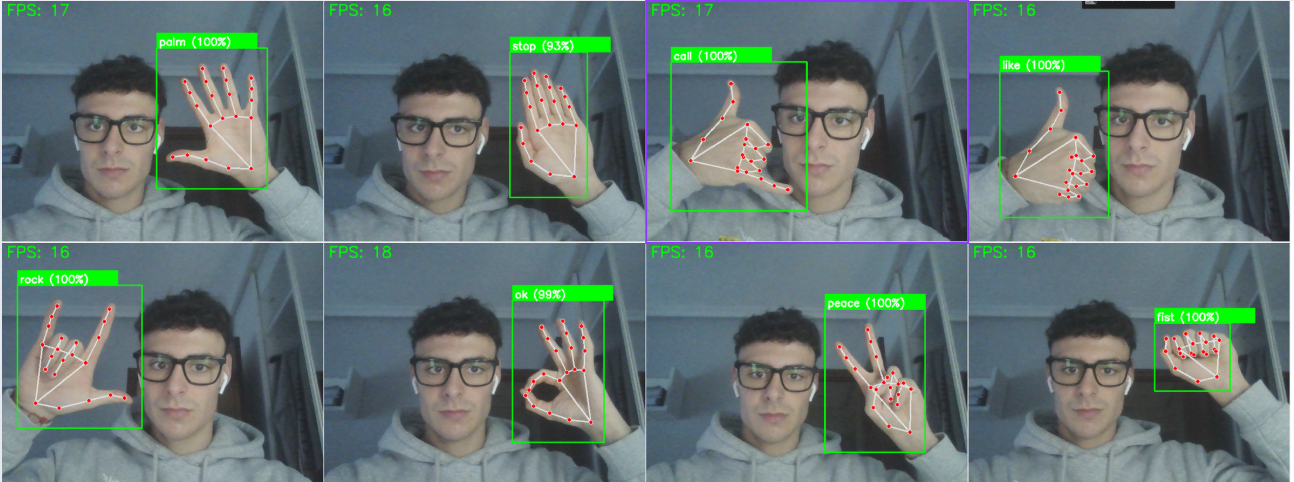













































Se puede apreciar como el modelo es prácticamente perfecto (obviando detalles), pues reconoce con claridad cada gesto con un **100% de confianza** en su mayoría. Esto justifica el correcto funcionamiento del modelo elegido: `ResNet18`. Como hemos comentado antes, esta red tiene un equilibrio perfecto: una precisión robusta y una velocidad lo suficientemente rápida como para captar en tiempo real cada *frame* sin sobrecargar la CPU, por lo que la elección justificada del modelo ha sido **correcta**.

Sin embargo, hay un pequeño conflicto, pues resulta que los gestos `stop` y `palm` son casi idénticos: lo único en lo que difieren es en la separación entre dedos:
* si los dedos están **completamente cerrados**, se detecta un `stop`
* si el modelo nota **cualquier ápice de separación** en algún dedo, detecta un `palm`

De hecho, se puede apreciar que, aunque se haga el gesto `stop`, el modelo no garantiza una confianza del 100% ya que contempla la posibilidad de que el gesto pueda ser realmente un `palm`, por eso el 93% que aparece en la demo.

## <font color = 'purple'>**COMPARACIÓN 1: Template Matching vs Deep Learning**

Tras implementar y evaluar ambas estrategias de localización y clasificación de gestos, procedemos a realizar una comparación directa de lo que hemos experimentado. Esta comparativa es necesaria para justificar el gran salto sufrido desde algoritmos deterministas (*Template Matching*) hacia modelos estocásticos aprendidos (*Deep Learning*).

A continuación, se presenta una **tabla comparativa** que sintetiza las métricas y comportamientos observados durante las fases experimentales:

| Característica / Métrica | **Template Matching** | **Deep Learning (ResNet18 + Augmentation)** | **"Ganador"** |
| :--- | :--- | :--- | :--- |
| **Naturaleza del Algoritmo** | Determinista (Correlación de píxeles) | Estocástico / Aprendido (Extracción de características) | **DL** (Mayor capacidad de abstracción) |
| **Representación del Gesto** | Plantilla estática (Base de datos manual) | Pesos entrenados | **DL** (Mayor flexibilidad) |
| **Robustez Morfológica** | **Baja**. Muchas confusiones entre clases no tan similares (`rock` vs `call` con score 0.66). | **Muy Alta**. Accuracy > 99%. Distingue matices finos gracias a las capas profundas. | **DL** |
| **Invarianza a la Escala** | Nula. Requiere que el objeto tenga el tamaño exacto de la plantilla. | Alta. El modelo y el *Data Augmentation* asimilan cambios de tamaño. | **DL** |
| **Invarianza a la Rotación** | Nula. Un giro leve de muñeca rompe la correlación. | Alta. Soporta rotaciones aprendidas durante el entrenamiento. | **DL** |
| **Sensibilidad al Fondo** | Crítica. El algoritmo procesa el fondo como parte del gesto. | Baja. Las convoluciones aprenden a filtrar el ruido y centrarse en la mano. | **DL** |
| **Rendimiento (Inferencia)** | Dependiente del número de plantillas ($O(N)$). Lento si escalamos clases. | Constante ($O(1)$) una vez entrenado. ~527 FPS en GPU. | **DL** |
| **Métrica Principal** | Score NCC Promedio: **< 0.6** (muy inestable) | Accuracy Test: **99.14%** (muy robusto) | **DL** |

**Rigidez fisionómica vs Abstracción**

  - Las pruebas realizadas en el apartado de **Template Matching** evidencian un fallo repetitivo: la **falsa correlación**. Al depender de una operación matemática píxel a píxel, el sistema clásico es incapaz de distinguir la semántica del gesto.

  * **Evidencia:** El sistema clasificó erróneamente un puño (`rock`) como una llamada (`call`) con un 66% de confianza simplemente porque los contornos coincidían, ignorando la posición de los dedos.
  * **Solución Deep Learning:** La **ResNet18**, gracias a sus capas convolucionales, no compara píxeles brutos, sino que extrae **características jerárquicas**. Esto le permite a la red "entender" que un puño cerrado es un puño, independientemente de si la sombra es ligeramente distinta, logrando un **F1-Score del 99%** en el mismo sitio en el que el método clásico fallaba aleatoriamente.

**La batalla contra el Ruido**

  * **Template Matching:** En nuestros experimentos, observamos que las plantillas incluían "trozos" de fondo o ropa. El algoritmo de Correlación Cruzada Normalizada (NCC) buscaba en la imagen en vivo no solo la mano, sino *esa mano con ese fondo específico*. Si el usuario cambiaba de habitación o la iluminación variaba, el *score* de coincidencia caía drásticamente (< 0.4), resultando en falsos negativos.
  * **Deep Learning:** Al utilizar un dataset masivo (**HaGRID**) con miles de fondos distintos y aplicar **Data Augmentation** (cambios de brillo, contraste, ruido), la red neuronal aprendió a **extraer el objeto del fondo**. La red "ignora" el entorno y centra su atención en la geometría de la mano, proporcionando muchísima robustez para la aplicación.

**Escalabilidad y Tiempo Real**

  * Para hacer que el *Template Matching* fuera medianamente robusto a la escala y rotación, tendríamos que haber generado miles de plantillas por cada gesto (una por cada grado de rotación y tamaño posible). Esto aumentaría muchísimp el tiempo de cómputo, haciendo inviable el procesamiento en tiempo real.

  * Por el contrario, la **ResNet18** condensa todo el conocimiento de las 24.000 imágenes de entrenamiento en un archivo de pesos de menos de 50MB. Su tiempo de inferencia es inferior a **2 ms en GPU**, independientemente de la variabilidad de la entrada, permitiendo una experiencia al usuario bastante fluida.

**Conclusión de la Comparativa**

Los resultados obtenidos demuestran que el **Template Matching** es una técnica muy limitada para problemas biométricos no controlados. Su dependencia de condiciones ideales (iluminación fija, pose estática, escala exacta) la hace insuficiente para una interfaz de usuario natural.

La implementación basada en **Deep Learning (ResNet18)** supera todas las limitaciones detectadas en la fase clásica. No solo ofrece una precisión superior al 99%, sino que aporta la **elasticidad** necesaria para lidiar con todas las imperfecciones del movimiento humano que se le presenten.

Por tanto, descartamos definitivamente el enfoque clásico y adoptamos el modelo neuronal (**ResNet18**) como el núcleo de nuestro sistema.

## <font color = 'purple'>**COMPARACIÓN 2: Data Augmentation vs SIN Data Augmentation**

La segunda gran comparativa de este proyecto radica en la estrategia de entrenamiento. **¿Es suficiente con enseñar al modelo las 24.000 imágenes originales, o es necesario "perturbar" artificialmente estos datos para hacerlo más robusto?**

En el primer entrenamiento (Sin Data Augmentation), el modelo se entrebna con datos limpios y estáticos. En el segundo (Data Augmentation), introducimos caos controlado: rotaciones, cambios de luz, zoom y deformaciones. A continuación, contrastamos el impacto de ambas estrategias sobre nuestro modelo candidato final (**ResNet18**) y el comportamiento general de las arquitecturas:

| Característica / Métrica | **Sin Data Augmentation** | **Con Data Augmentation** | **"Ganador"** |
| :--- | :--- | :--- | :--- |
| **Aprendizaje** | Tendencia a la **Memorización**. Aprende "esa foto" exacta. | **Generalización**. Aprende el concepto invariante de la mano. | **Con Augmentation** |
| **Accuracy (ResNet18)** | 98.57% | **99.14%** (+0.57%) | **Con Augmentation** |
| **Estabilidad de la pérdida** | Pérdida de validación baja (0.05), pero riesgo de divergencia en real. | Pérdida de validación más baja aún (0.026) y consistente. | **Con Augmentation** |
| **Comportamiento ante la luz** | Frágil. Un cambio de brillo puede tumbar la predicción. | Robusto. Entrenado con `max_lighting=0.4`, tolera sombras y sobreexposición. | **Con Augmentation** |
| **Comportamiento espacial** | Rígido. Asume la mano centrada y recta. | Flexible. Tolera rotaciones ($\pm 15^\circ$) y cambios de distancia (Zoom 10%). | **Con Augmentation** |
| **Impacto en modelos pequeños** | Alto rendimiento (MobileNetV3: 96.79%). | Ligera degradación (MobileNetV3: 95.6%). La variabilidad satura redes pequeñas. | **Depende del Hardware** |
| **Viabilidad en tiempo real** | **Peligrosa**. El entorno real nunca es idéntico al dataset. | **Óptima**. Simula condiciones adversas. | **Con Augmentation** |

**La "falsa" precisión sin Augmentation**

  - Al entrenar sin *Data Augmentation*, obtuvimos métricas muy altas (**ResNet152** con 99.16%). Sin embargo, esto es conocido como **sobreajuste contextual**.
  - El modelo no estaba aprendiendo necesariamente la morfología del gesto, sino correlaciones ficticias: "si hay un píxel blanco en la esquina (fondo) y una mancha color carne en el centro, es un OK". En un entorno controlado (dataset de validación similar al de entrenamiento), esto funciona. Pero en una webcam en tiempo real, donde el fondo y la luz cambian, este modelo fallaría estrepitosamente.

**Salto de calidad en ResNet18**

  - El caso de **ResNet18** es el ejemplo perfecto de por qué el *Augmentation* es obligatorio.
    * **Sin Augmentation:** 98.57%.
    * **Con Augmentation:** 99.14%.

  - Aunque la mejora numérica parece pequeña (0.6%), cualitativamente es gigante. Ese 0.6% representa los casos donde las manos están ligeramente giradas, están más alejadas o bajo luz pobre,... Al introducir transformaciones (`max_rotate=15.0`, `max_lighting=0.4`), hemos forzado a la red a desarrollar invarianzas. Ahora, la red sabe que una mano rotada 10 grados sigue siendo una mano, algo que el primer modelo no sabía.

**Pruebas en tiempo real con nuestro modelo final**

A continuación se proponen una serie de ejemplos de ejecuciones del modelo **con *Data Augmentation* vs sin *Data Augmentation*** en las que se aprecia la eficacia que provoca este recurso en una red de entrenamiento:

| Data Augmentation | No Data Augmentation |
| ---------------------------- | ---------------------------- |
| 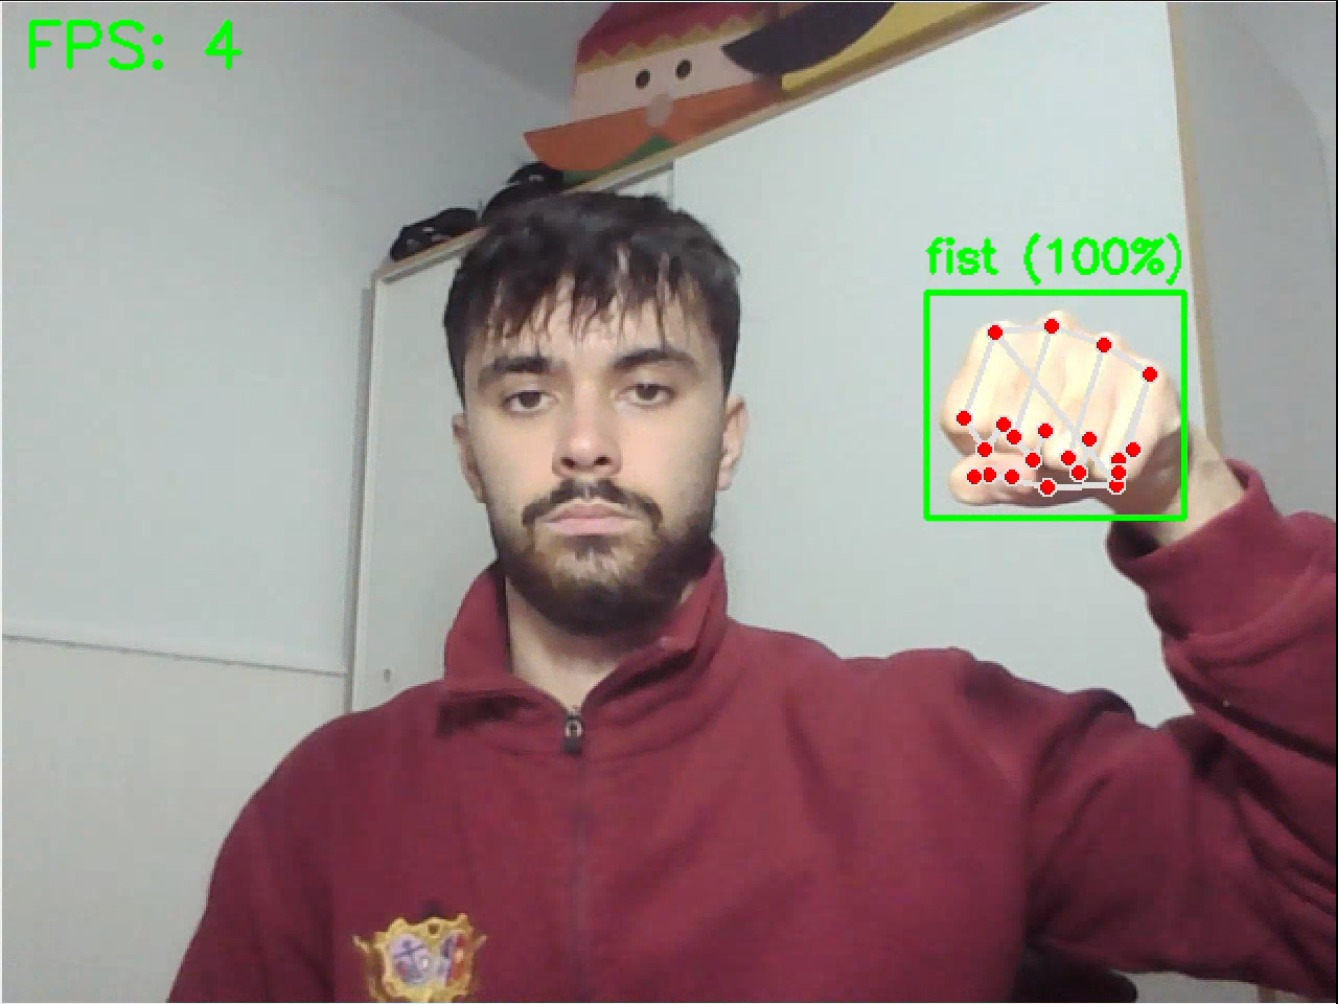 | 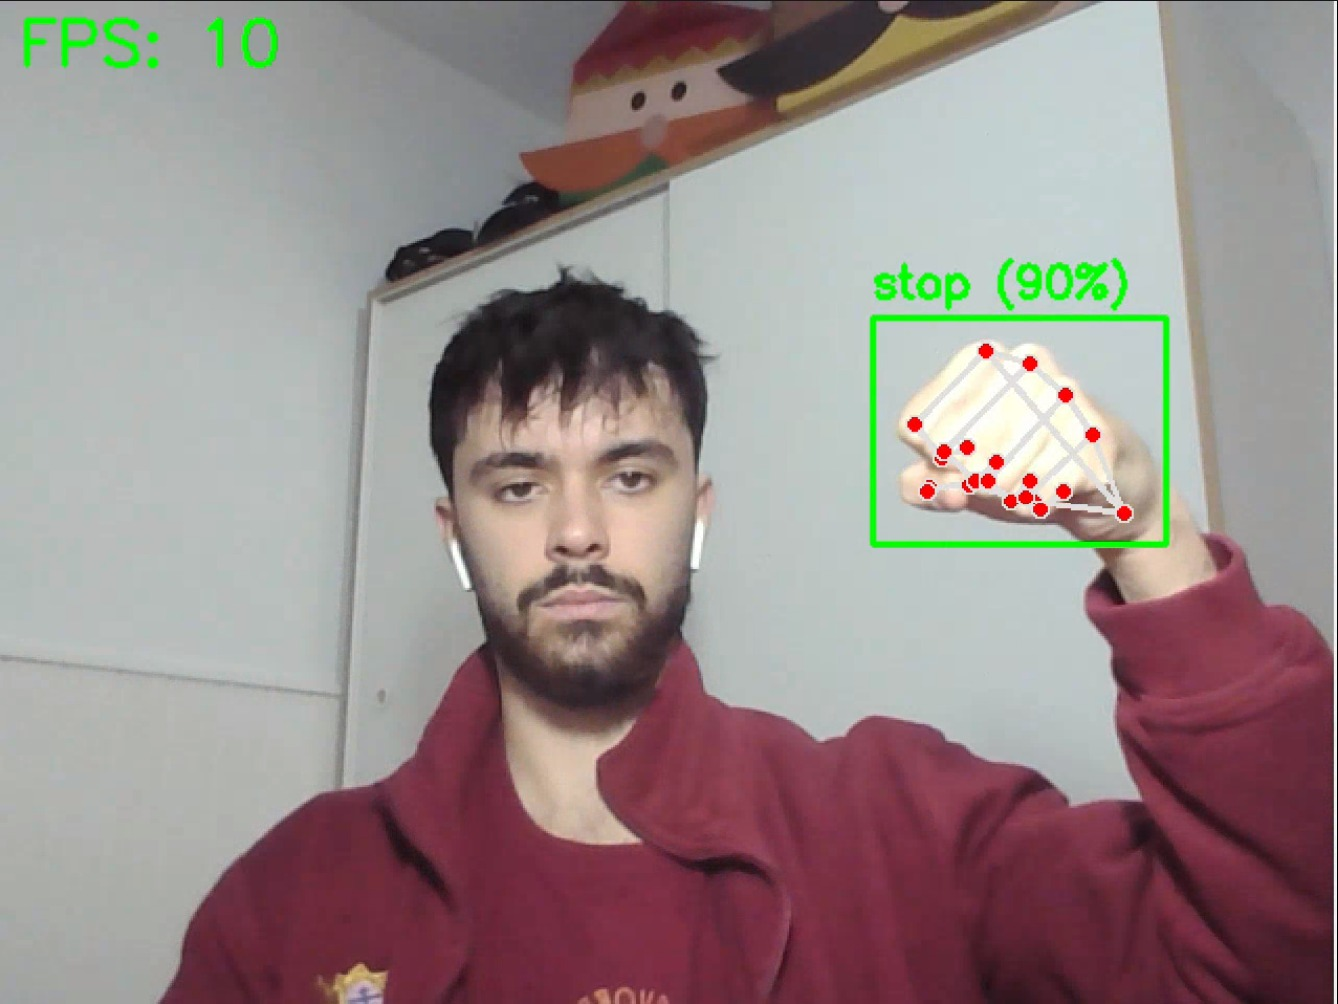 |

Aquí se puede apreciar cómo en el modelo en el que se usa ***Data Augmentation***, al cerrar el puño en dirección perpendicular a la cámara, el modelo detecta a la perfección el gesto `fist`, correspondiente al gesto que cierra el puño.

Sin embargo, en el modelo en el que no se usa ***Data Augmentation***, al reproducir prácticamente el mismo gesto, no detecta `fist`, pero es que, además, detecta `stop` con un 90% de confianza, demostrando que si en el modelo que no usa esta técnica de regularización se capta una imagen en la que el gesto se produce en unas condiciones distintas a las comunes que se han entrenado, el modelo **no capta correctamente** dicho gesto, llegando incluso a detectar otro gesto, en este caso `stop` cuando éste no se corresponde con los píxeles que describen dicho gesto.

Veamos otro caso:

| Data Augmentation | No Data Augmentation |
| ---------------------------- | ---------------------------- |
| 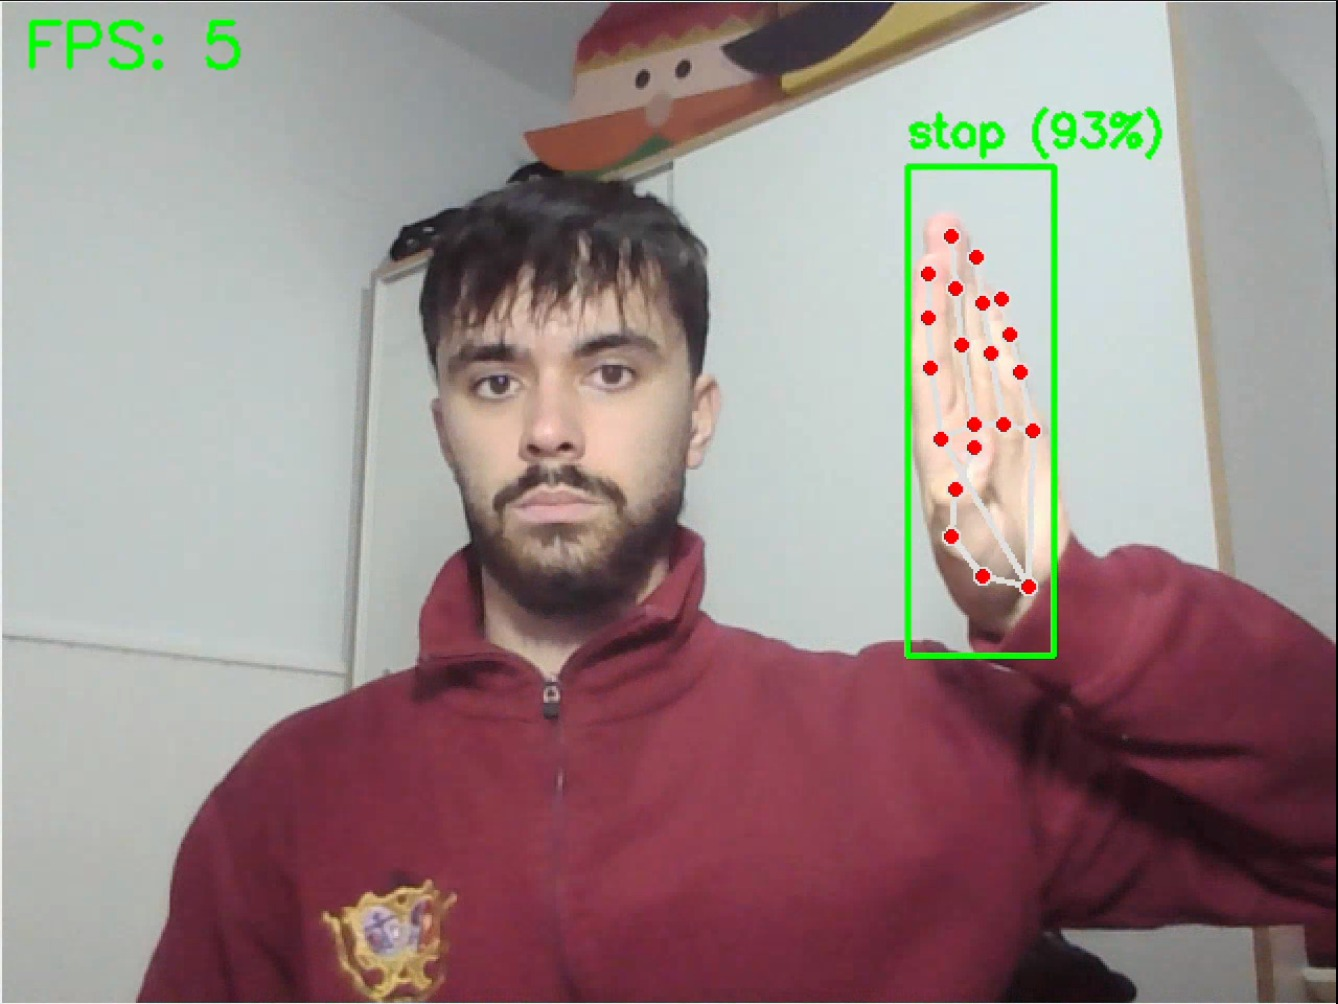 | 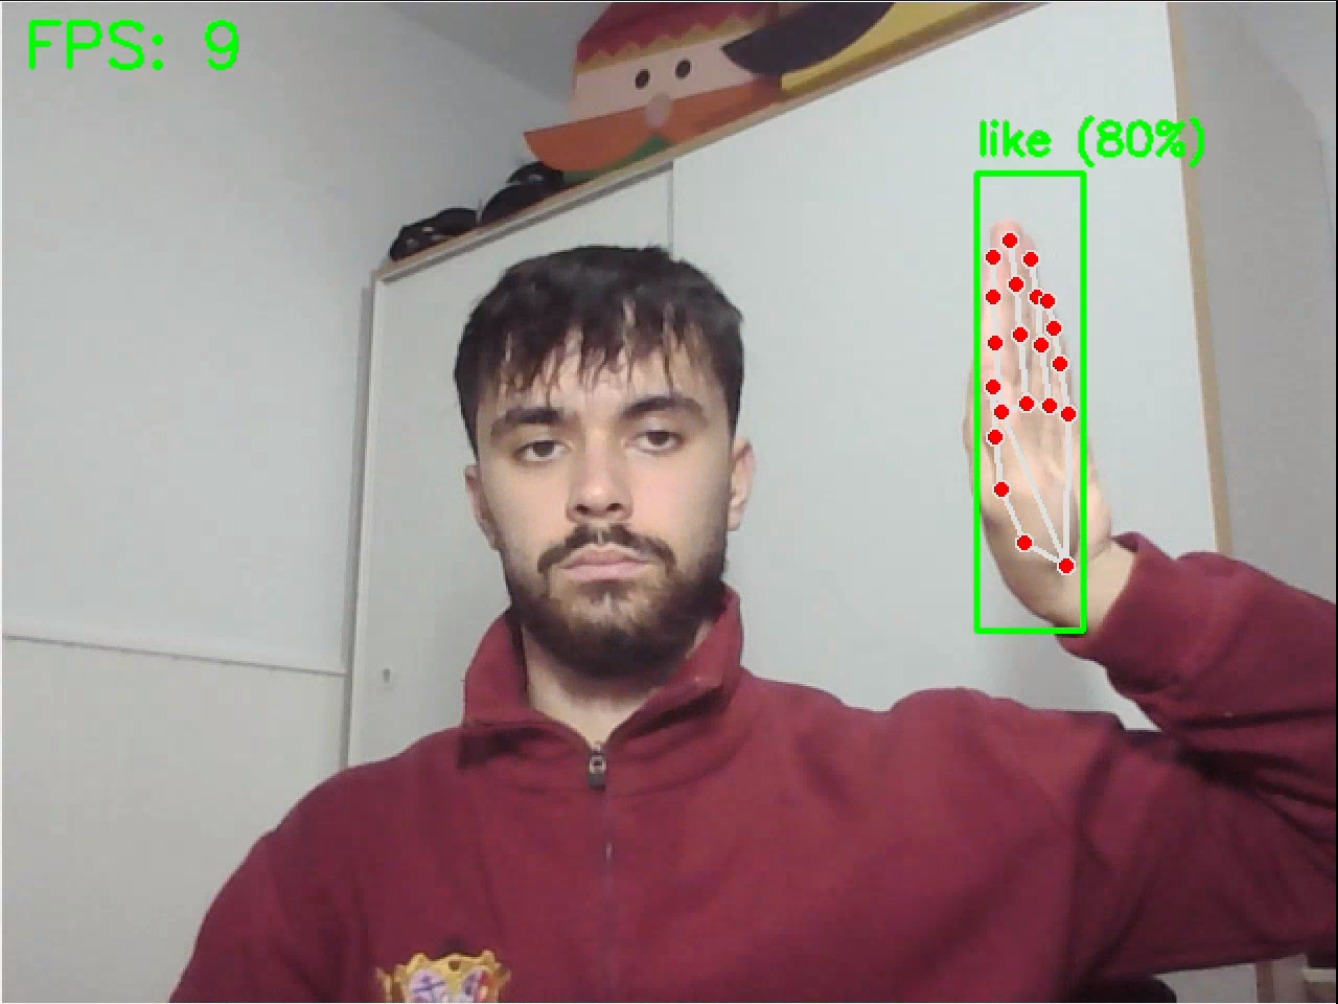 |

De nuevo, vemos cómo al presentarse un gesto de `stop` de una manera poco común a lo visto en el dataset, el modelo con la técnica de regularización aplicada detecta el gesto que se está realizando correctamente, aunque no al 100% debido a los cambios en el contexto de la imagen, ya que ***Data Augmentation*** realiza cambios geométricos pero no se presenta en dicha transformación un caso idéntico al actual.

No obstante, se aprecia cómo el modelo que no usa ***Data Augmentation*** detecta un gesto distinto, en este caso `like` con una confianza del 80%, afirmando, de nuevo, que **no usar esta técnica** en problemas como reconocimiento de gestos **es un error**, pues la interacción humano-computadora se ve comprometida por diversos cambios tanto en la fisionomía del humano como en el entorno de la imagen.

Veamos otro ejemplo:

| Data Augmentation | No Data Augmentation |
| ---------------------------- | ---------------------------- |
| 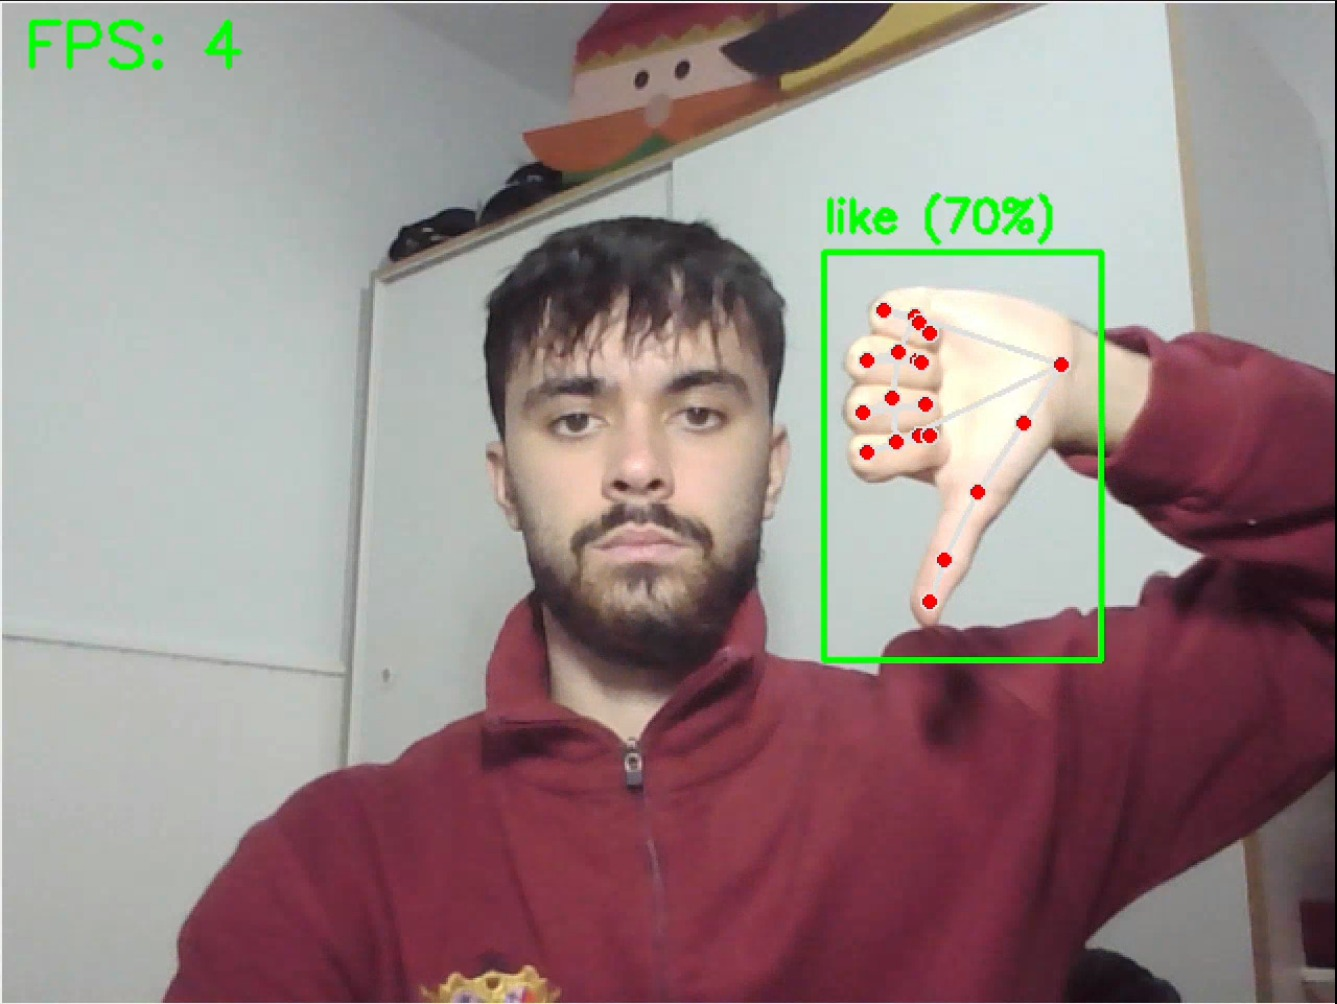 | 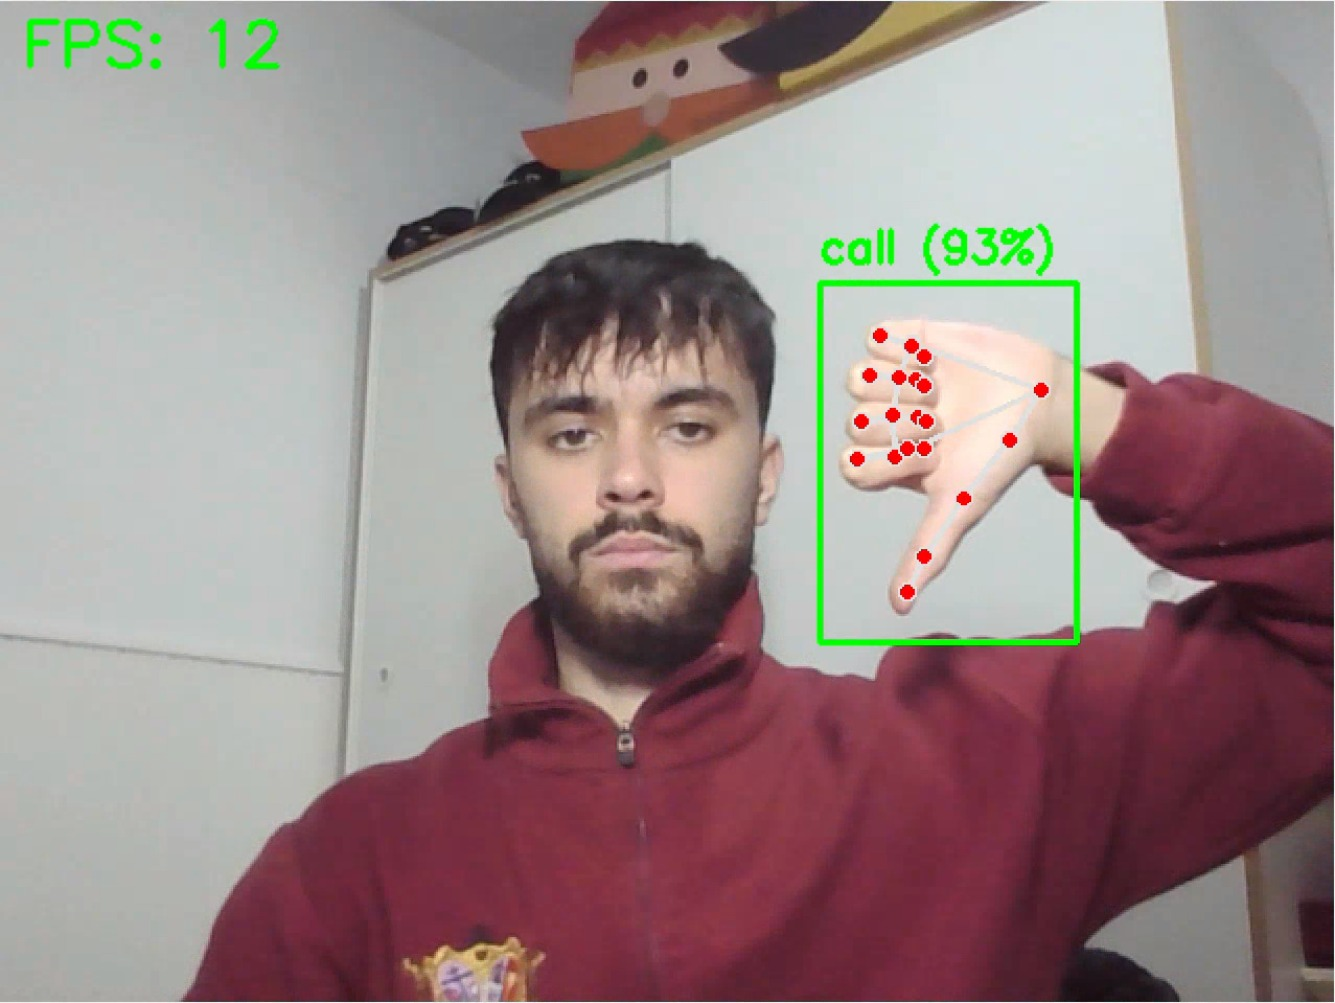 |

En este caso se presenta un gesto `like` pero dado la vuelta hacia abajo, un caso extraordinario a lo visto en el dataset.

En el caso del modelo con ***Data Augmentation***, como se trata de una imagen corporal distinta a lo aprendido, detecta el gesto correctamente, pero con una confianza del 70%, caso que haría dudar o no del modelo **según un umbral establecido**, pero en términos generales, se afirmaría que el modelo detecta el gesto permitiendo confiar más en él que dudar sobre él.

Sin embargo, vemos cómo de nuevo el modelo básico no detecta el gesto correctamente, es más, detecta otro gesto, en este caso `call` (debido al pulgar abierto estando cerca de la cabeza), por lo que, de nuevo, se aprecia **cómo de útil es la técnica de regularización** planteada al inicio de esta implementación.

Vamos a ver un último ejemplo en el que la iluminación y la distancia afectan al modelo:

| Data Augmentation | No Data Augmentation |
| ---------------------------- | ---------------------------- |
| image.png | 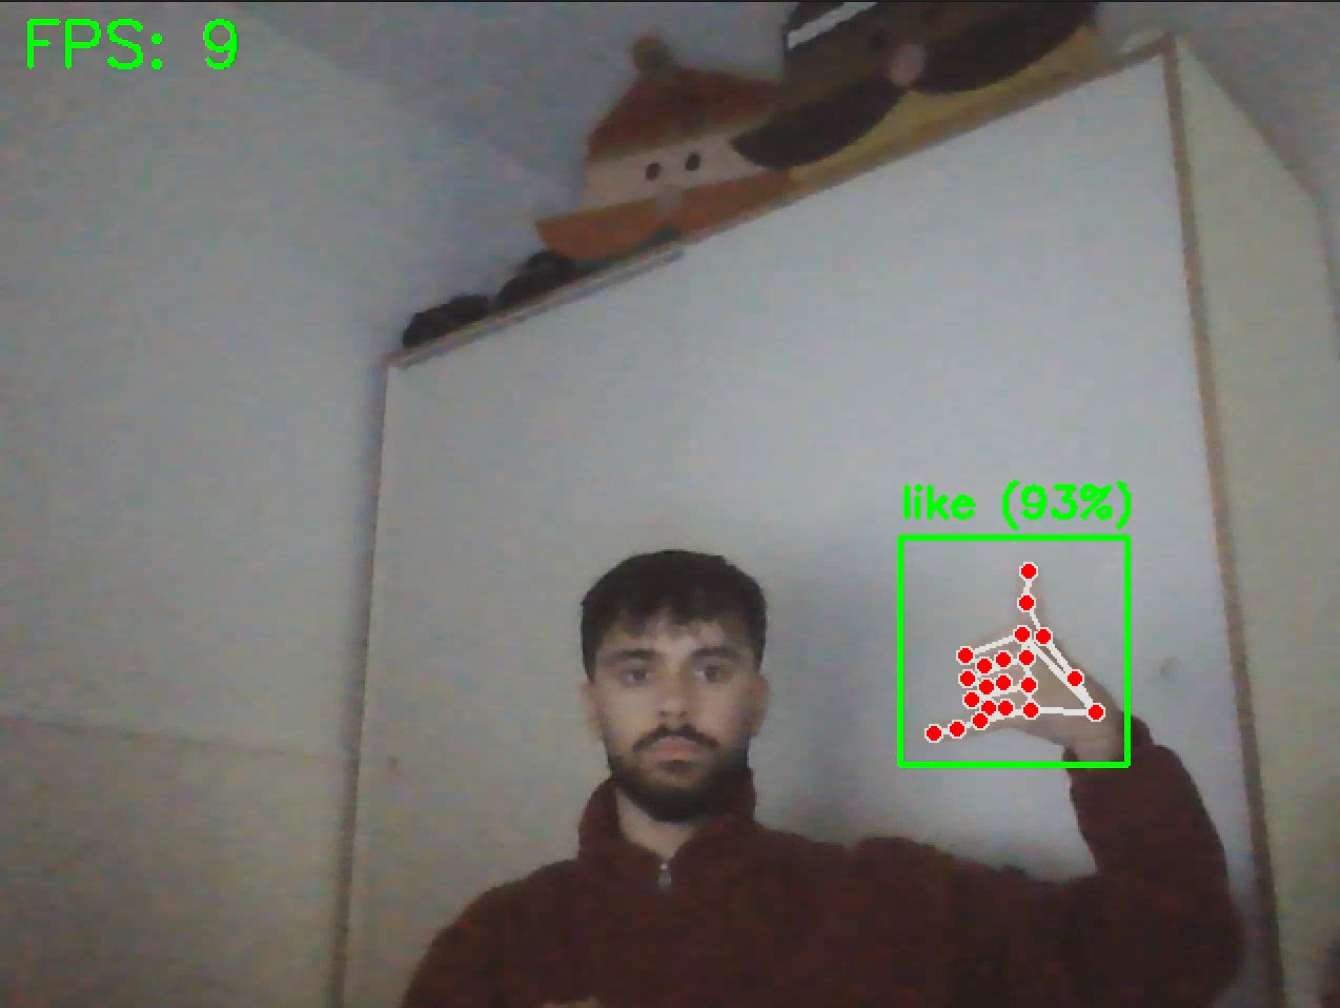 |

Vemos cómo el modelo que usa ***Data Augmentation*** aplica transformaciones en la intensidad de la luz, por lo que a la hora de presentar una imagen de intensidad distinta a la del dataset para un gesto, no tiene problema en detectar el gesto correcto, en este caso `call`, con el pulgar y el meñique abiertos.

En el caso del modelo básico, como para el gesto `call` no habrá imágenes parecidas a esta con una iluminación más baja de lo normal a una distancia determinada de la cámara, el modelo detecta `like`, un gesto erróneo con el presentado realmente. Esto evidencia de nuevo, que el uso de ***Data Augmentation*** en problemas de interacción persona-ordenador en tiempo real es **necesario**, pues la interacción puede llevar consigo cambios de iluminación, de distancia o en la fisionomía de la persona que interactúe.

**Conclusión**

La comparación demuestra que, para una aplicación de **Interacción Persona-Ordenador** en tiempo real, el *Data Augmentation* no es opcional, es un requisito necesario.

* El modelo entrenado **sin augmentation** es muy bueno con las fotos que ya conoce, pero frágil ante la novedad.
* El modelo entrenado **con augmentation** es un "todoterreno", preparado para el caos de una webcam no controlada.

Por tanto, el modelo final exportado (`modelo_gestos_resnet18_final.pkl`) es exclusivamente el entrenado con técnicas de **Data Augmentation**, garantizando así la fiabilidad del sistema ante usuarios, entornos e iluminaciones diversas.

## <font color = 'red'>**IMPLEMENTACIÓN 3: ¿Qué pasaría si no recortáramos la región de interés?**

### **Preprocesamiento de datos**

El dataset original **HaGRID** tiene un volumen excesivamente grande (cientos de GBs) y una estructura compleja distribuida en subconjuntos (train/val/test) y metadatos externos (annotations JSON) que contienen las coordenadas de la mano de cada imagen.

Para resolver esto, hemos implementado una limpieza del dataset en 8 clases en dos fases, utilizando dos entornos diferenciados:

  - **Entorno de descarga (Almacenamiento disponible: 2TB)**: Se utilizó una cuenta con 2 TB de almacenamiento para guardar los datos crudos. Aquí se ejecutó el siguiente script de ETL (Extract, Transform, Load) para procesar las imágenes. La jerarquía original era esta:

      ```text
    hagrid_data/
    ├── annotations/                  # Metadatos (Coordenadas Bounding Box)
    │   ├── train/
    │   │   ├── ok.json               # Contiene: "img_01.jpg": [x, y, w, h]
    │   │   └── ...
    │   ├── test/
    │   └── valid/
    └── dataset/                      # Imágenes originales (Full HD / 4K)
        ├── ok/
        │   ├── img_01.jpg            # Imagen completa (Mano + Fondo + Ruido)
        │   └── ...
        ├── palm/
        └── ...

  - **Entorno de desarrollo del proyecto (Colab Pro)**: Se transfiere a esta cuenta el dataset optimizado, maximizando el uso de la GPU y eliminando cuellos de botella de lectura a disco. Los archivos .json que teníamos anteriormente contenían coordenadas $(x, y, w, h)$ que apuntaban a dónde está la mano en la foto original gigante. Como ya henmos indicado, en esta fase estos los obviamos, ya que vamos a intentar que nuestro modelo aprenda con las imágenes enteras ruidosas.
  En el nuevo dataset limpio, el nombre de la carpeta es la etiqueta. Por tanto, si la foto está en /dataset_final_1/ok/imagen.jpg, PyTorch ya sabe que es un "OK", sin necesidad de leer ningún archivo de texto para saberlo. La nueva estructura limpia será:

    ```text
      dataset_final_proyecto1/
    ├── ok/
    │   └── 123.jpg
    ├── palm/
    │   └── ...
    └── ...

In [ ]:
# # # import os
# # # import random
# # # from PIL import Image
# # # from tqdm import tqdm
# # # from google.colab import drive
# # # drive.mount('/content/drive')

# # # INPUT_ROOT = "/content/drive/MyDrive/hagrid_data/dataset"
# # # OUTPUT_ROOT = "/content/drive/MyDrive/hagrid_data_processed_nocrop"
# # # IMAGES_PER_CLASS = 3000
# # # TARGET_SIZE = (224, 224)  # (width, height)
# # # SEED = 42

# # # random.seed(SEED)

# # # os.makedirs(OUTPUT_ROOT, exist_ok=True)

# # # classes = sorted([
# # #     d for d in os.listdir(INPUT_ROOT)
# # #     if os.path.isdir(os.path.join(INPUT_ROOT, d))
# # # ])

# # # print("Clases encontradas:", classes)

# # # for cls in classes:
# # #     input_dir = os.path.join(INPUT_ROOT, cls)
# # #     output_dir = os.path.join(OUTPUT_ROOT, cls)
# # #     os.makedirs(output_dir, exist_ok=True)

# # #     # Lista de imágenes
# # #     images = [
# # #         f for f in os.listdir(input_dir)
# # #         if f.lower().endswith((".jpg", ".jpeg", ".png"))
# # #     ]

# # #     if len(images) < IMAGES_PER_CLASS:
# # #         print(f" {cls}: solo {len(images)} imágenes disponibles")
# # #         selected = images
# # #     else:
# # #         selected = random.sample(images, IMAGES_PER_CLASS)

# # #     print(f"{cls}: procesando {len(selected)} imágenes")

# # #     for img_name in tqdm(selected, desc=cls):
# # #         src_path = os.path.join(input_dir, img_name)
# # #         dst_path = os.path.join(output_dir, img_name)

# # #         try:
# # #             with Image.open(src_path) as img:
# # #                 img = img.convert("RGB")
# # #                 img = img.resize(TARGET_SIZE, Image.BILINEAR)
# # #                 img.save(dst_path, quality=95)
# # #         except Exception as e:
# # #             print(f"Error con {src_path}: {e}")

# # # print("Proceso terminado")


Una vez ejecutado el anterior código en la otra cuenta, tenemos en el drive de esta cuenta la carpeta `hagrid_data_processed_nocrop.zip`.

Nos la **descargamos en nuestro PC** y **la subimos a la cuenta en la que se desarrollará todo el proyecto**, es decir, sobre la que estamos trabajando actualmente.

Una vez que tenemos en nuestra cuenta de trabajo el archivo `content/drive/MyDrive/hagrid_data_processed_nocrop.zip`, vamos a descomprimirla para trabajar con este dataset. Este código **SOLO SE TIENE QUE EJECUTAR UNA VEZ**, por lo que tras ejecutarlo la primera vez lo comentamos para que en posteriores ejecuciones no se ejecute y de error.

In [ ]:
# # DESCOMPRESIÓN DEL DATASET
# import os
# import zipfile
# from google.colab import drive
# from tqdm import tqdm

# # Montamos Drive
# drive.mount('/content/drive')

# ZIP_PATH = "/content/drive/MyDrive/hagrid_data_processed_nocrop.zip"

# # Esta será la carpeta PERMANENTE en nuestro Drive
# PERMANENT_DIR = "/content/drive/MyDrive/hagrid_data_processed_nocrop"

# def install_dataset_permanently():

#     print(f"Origen: {ZIP_PATH}")
#     print(f"Destino: {PERMANENT_DIR}")

#     try:
#         with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
#             # Extraemos todo
#             zip_ref.extractall(PERMANENT_DIR)

#         print("\n¡INSTALACIÓN COMPLETADA!")
#         print(f"Las imágenes están en: {PERMANENT_DIR}")

#     except Exception as e:
#         print(f"Error: {e}")

# # Ejecutamos la instalación
# install_dataset_permanently()

Ahora sí, cargamos los datos a nuestro cuaderno:

In [ ]:
from fastai.vision.all import *
from google.colab import drive
drive.mount('/content/drive')


DATASET_DIR= Path("/content/drive/MyDrive/hagrid_data_processed_nocrop")



### **Comparación de modelos pre-entrenados**


In [ ]:
from fastai.vision.all import *
from pathlib import Path
import os
from google.colab import drive
drive.mount('/content/drive')

NO_CROP_DIR = "/content/drive/MyDrive/hagrid_data_processed_nocrop"
path = Path(NO_CROP_DIR)

In [ ]:
# CONFIGURACIÓN DEL DATA BLOCK CON DATA AUGMENTATION

# Definimos las transformaciones que simulan el uso real
# - mult=1.5: Intensidad de la augmentación (moderada)
# - do_flip=True: Para que aprenda mano izquierda/derecha indistintamente
# - max_rotate=15.0: Rotación de muñeca realista (más de 15º podría cambiar el significado de algunos gestos)
# - max_zoom=1.1: Pequeños cambios de distancia a la cámara
# - max_warp=0.2: Cambios de perspectiva (mano no totalmente paralela a la cámara)
# - p_lighting=0.75: Alta probabilidad de cambio de luz

mis_transformaciones = aug_transforms(
    mult=1.5,
    do_flip=True,
    flip_vert=False,
    max_rotate=15.0,
    max_zoom=1.1,
    max_lighting=0.4,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75
)

# Creamos el nuevo DataBlock "Robusto"
gestos_block_aug = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224), # Resize en CPU
    batch_tfms=[*mis_transformaciones, Normalize.from_stats(*imagenet_stats)] # Augmentations + Normalización en GPU
)

# Cargar los datos
dls = gestos_block_aug.dataloaders(path, bs=32)

# VISUALIZACIÓN
dls.show_batch(max_n=9, unique=True, figsize=(8,8))

#### <font color = 'orange'>**Resnet152**

In [ ]:
learn = vision_learner(
    dls,
    resnet152,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")

In [ ]:
learn.fine_tune(3, base_lr=lr[0])

In [ ]:
learn.recorder.plot_metrics()

Al evaluar el modelo `ResNet152` utilizando las imágenes completas, obtenemos un ***accuracy* final del 96.12%**.

Si contrastamos estos datos con el **99.16%** de acierto obtenido en la fase anterior (imágenes recortadas), observamos una **caída de rendimiento del 3%**. Este descenso confirma la hipótesis planteada al inicio del proyecto: *aunque `ResNet152` es una red extremadamente potente capaz de ignorar gran parte del ruido, el fondo de la imagen introduce una complejidad significativa que penaliza la clasificación*.

La pérdida de validación final se sitúa en **0.121**, un valor considerablemente más alto que el **~0.024** logrado con el dataset recortado. Esto indica que, sin la etapa de detección previa, el modelo tiene mucha menos "seguridad" en sus predicciones, ya que debe luchar contra la variabilidad del entorno para encontrar los patrones de la mano.

#### <font color = 'orange'>**Resnet18**

In [ ]:
learn_2 = vision_learner(
    dls,
    resnet18,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_2.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")

In [ ]:
learn_2.fine_tune(3, base_lr=lr[0])

In [ ]:
learn_2.recorder.plot_metrics()


Los resultados obtenidos con `ResNet18` resaltan ya que el modelo alcanza un ***accuracy* final del 83.21%**, con una pérdida de validación que se estanca en **0.456**.

El contraste con la fase anterior supone una bajada considerable: hemos pasado de un **98.57%** de precisión con imágenes recortadas a apenas un **83%** con imágenes completas. Esta caída de más de **un 15%** evidencia la limitación arquitectónica de `ResNet18`. Al ser una red más superficial, carece de la profundidad y la capacidad de abstracción necesarias para filtrar eficazmente el ruido del fondo y centrarse exclusivamente en la mano.

A diferencia de `ResNet152`, que lograba mantener el tipo gracias a su inmensa cantidad de parámetros, `ResNet18` sufre enormemente cuando no se le entrega la mano aislada. Esto confirma una conclusión vital para el despliegue del proyecto: **si queremos utilizar modelos ligeros optimizados para tiempo real, la etapa de detección y recorte es obligatoria**, ya que el modelo por sí solo no tiene la capacidad suficiente para ignorar el entorno.

#### <font color = 'orange'>**EfficientNet_B0**

In [ ]:
learn_3 = vision_learner(
    dls,
    efficientnet_b0,
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_3.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")

In [ ]:
learn_3.fine_tune(3, base_lr=lr[0])


In [ ]:
learn_3.recorder.plot_metrics()


Los resultados para `EfficientNet_B0` son **críticos** y marcan el punto de inflexión en este experimento: el modelo baja drásticamente hasta un ***accuracy* del 48.06%**.

Estamos ante el caso más drástico de degradación por ruido de fondo. Si recordamos la fase anterior, este modelo alcanzaba un **97.68%** de precisión con imágenes recortadas. Pasar de casi un 98% a un 48% demuestra que la arquitectura *EfficientNet* carece de la capacidad necesaria para filtrar fondos complejos por sí sola.

Con una pérdida de validación final de **1.389**, el modelo muestra una clara incapacidad para converger adecuadamente. Esto confirma que, para arquitecturas ligeras y eficientes como esta, es necesario contar con una etapa previa que elimine el ruido. Sin el recorte, `EfficientNet_B0` resulta inutilizable para esta tarea.

#### <font color = 'orange'>**MobileNETV3 (Large)**

In [ ]:
learn_4 = vision_learner(
    dls,
    'mobilenetv3_large_100',
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_4.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")

In [ ]:
learn_4.fine_tune(3, base_lr=lr[0])


In [ ]:
learn_4.recorder.plot_metrics()


El rendimiento de `MobileNetV3` sufre un impacto severo al procesar las imágenes completas, alcanzando un ***accuracy* final del 63.46%**.

El contraste con la fase anterior es, de nuevo, decepcionante. Hemos pasado de un **96.79%** de precisión con imágenes recortadas a un **63.46%** en este escenario. `MobileNetV3` logra su velocidad utilizando convoluciones separables en profundidad y menos parámetros, lo que limita su "capacidad de representación" para filtrar fondos complejos y ruidosos.

Con una pérdida de validación en **0.998**, queda demostrado que este modelo no puede aprender a distinguir eficazmente los gestos si no se le da la mano aislada. Esto refuerza la arquitectura de nuestro sistema final: `MobileNetV3` es excelente para la inferencia rápida en CPU, pero depende totalmente de que una herramienta que realice el trabajo sucio de localización y recorte previo.

#### <font color = 'orange'>**ConveNeXt Tiny (CNN moderna)**

In [ ]:
learn_5 = vision_learner(
    dls,
    'convnext_tiny',
    pretrained=True,
    metrics=[accuracy, F1Score(average='macro')])

lr = learn_5.lr_find()

print(f"El learning rate recomendado es: {lr[0]}")

In [ ]:
learn_5.fine_tune(3, base_lr=lr[0])

In [ ]:
learn_5.recorder.plot_metrics()

Finalmente, el modelo `ConvNeXt Tiny` arroja un ***accuracy* del 96.25%**.

Al compararlo con la fase de imágenes recortadas (donde obtuvo un **99.16%**), vemos una caída de rendimiento cercana al **3%**, muy similar a la sufrida por `ResNet152`. Sin embargo, lo destacable es que esta arquitectura "Tiny", con una fracción de los parámetros de `ResNet152`, ha logrado igualar e incluso superar ligeramente el rendimiento de su competidora (96.25% vs 96.12%) en el escenario más difícil.

`ConvNeXt` demuestra una capacidad de abstracción superior, logrando filtrar el ruido del entorno con una eficiencia asombrosa. Además, su arranque en la época 0 (modelo congelado) fue del **65%**, muy superior al 51% de `ResNet152`, lo que sugiere que sus características pre-entrenadas son mucho más robustas. A pesar de este éxito, la pérdida de ese 3% de precisión final sigue justificando el uso del recorte para garantizar la máxima fiabilidad en la interfaz.

### **Elección del Modelo y Conclusión Arquitectónica**

Tras someter a las cinco arquitecturas al desafío de clasificar imágenes completas, los resultados muestran un escenario muy diferente al de la fase anterior:

| Modelo | Accuracy Final | F1-Score | Comportamiento |
| :--- | :---: | :---: | :--- |
| **ConvNeXt Tiny** | **96.25%** | **0.962** | **Excelente robustez ante el ruido de fondo.** |
| **ResNet152** | 96.12% | 0.961 | Muy sólido, igualando la capacidad de ConvNeXt. |
| **ResNet18** | 83.21% | 0.832 | Sufre una degradación severa (-15%). |
| **MobileNetV3** | 63.46% | 0.632 | Pierde su capacidad funcional (-33%). |
| **EfficientNet_B0** | 48.06% | 0.473 | Colapso total del modelo (-50%). |



Si queremos desplegar un sistema **sin detector de manos previo**, el ganador indiscutible sería **ConvNeXt Tiny**.
Este modelo ha demostrado que una arquitectura moderna posee la capacidad de atención necesaria para "encontrar" la mano entre el ruido, logrando un 96.25% de precisión y superando incluso a la masiva ResNet152.

Sin embargo, este experimento valida la tesis principal del proyecto:

1.  **El dilema de la eficiencia:** Los modelos ligeros (**MobileNet, ResNet18**), que son los únicos capaces de correr fluidamente en CPU, **fracasan de manera considerable** cuando hay ruido de fondo.
2.  **El coste de la precisión:** Para recuperar la precisión perdida por el fondo, estamos obligados a usar modelos pesados (**ConvNeXt, ResNet152**), pero como vimos en el análisis de tiempos, estos modelos son **demasiado lentos para tiempo real en CPU** (13-30 FPS).



### **EXPORTAMOS EL MEJOR MODELO PARA VER SU FUNCIONAMIENTO**

In [ ]:
# EXPORTACIÓN DEL MODELO GANADOR
import os

# Exportamos el modelo como archivo 'pickle' (.pkl)
# Esto guarda la arquitectura + los pesos aprendidos + las transformaciones necesarias
nombre_modelo = 'modelo_gestos_nocrop.pkl'
learn_5.export(nombre_modelo)

print(f"Modelo exportado correctamente.")

# Comprobamos que existe y vemos el tamaño
path_modelo = Path(nombre_modelo)
size_mb = path_modelo.stat().st_size / 1024 / 1024
print(f"Tamaño del archivo: {size_mb:.2f} MB")

# Descargamos en nuestro PC
from google.colab import files
files.download(nombre_modelo)

### **Pruebas en tiempo real**

Al probarlo, lo primero que notamos es que, a pesar de prescindir de MediaPipe/YOLO, los FPS son más bajos debido a lo pesado que es ConvNext. Además, ocurre que hay clases en las que las personas de las imágenes colocan la mano en un lugar que afecta a la predicción. Por ejemplo, en la clase *call*, las personas colocan su mano cerca de la cara simulando un "teléfono". Como resultado, el modelo ha aprendido erróneamente que la proximidad de la mano a la cara es una característica del gesto. Esto genera fallos de predicción si el usuario realiza el gesto, demostrando que el modelo no está clasificando la mano, sino la pose corporal completa. Se puede observar este fenómeno en las siguientes imagenes:
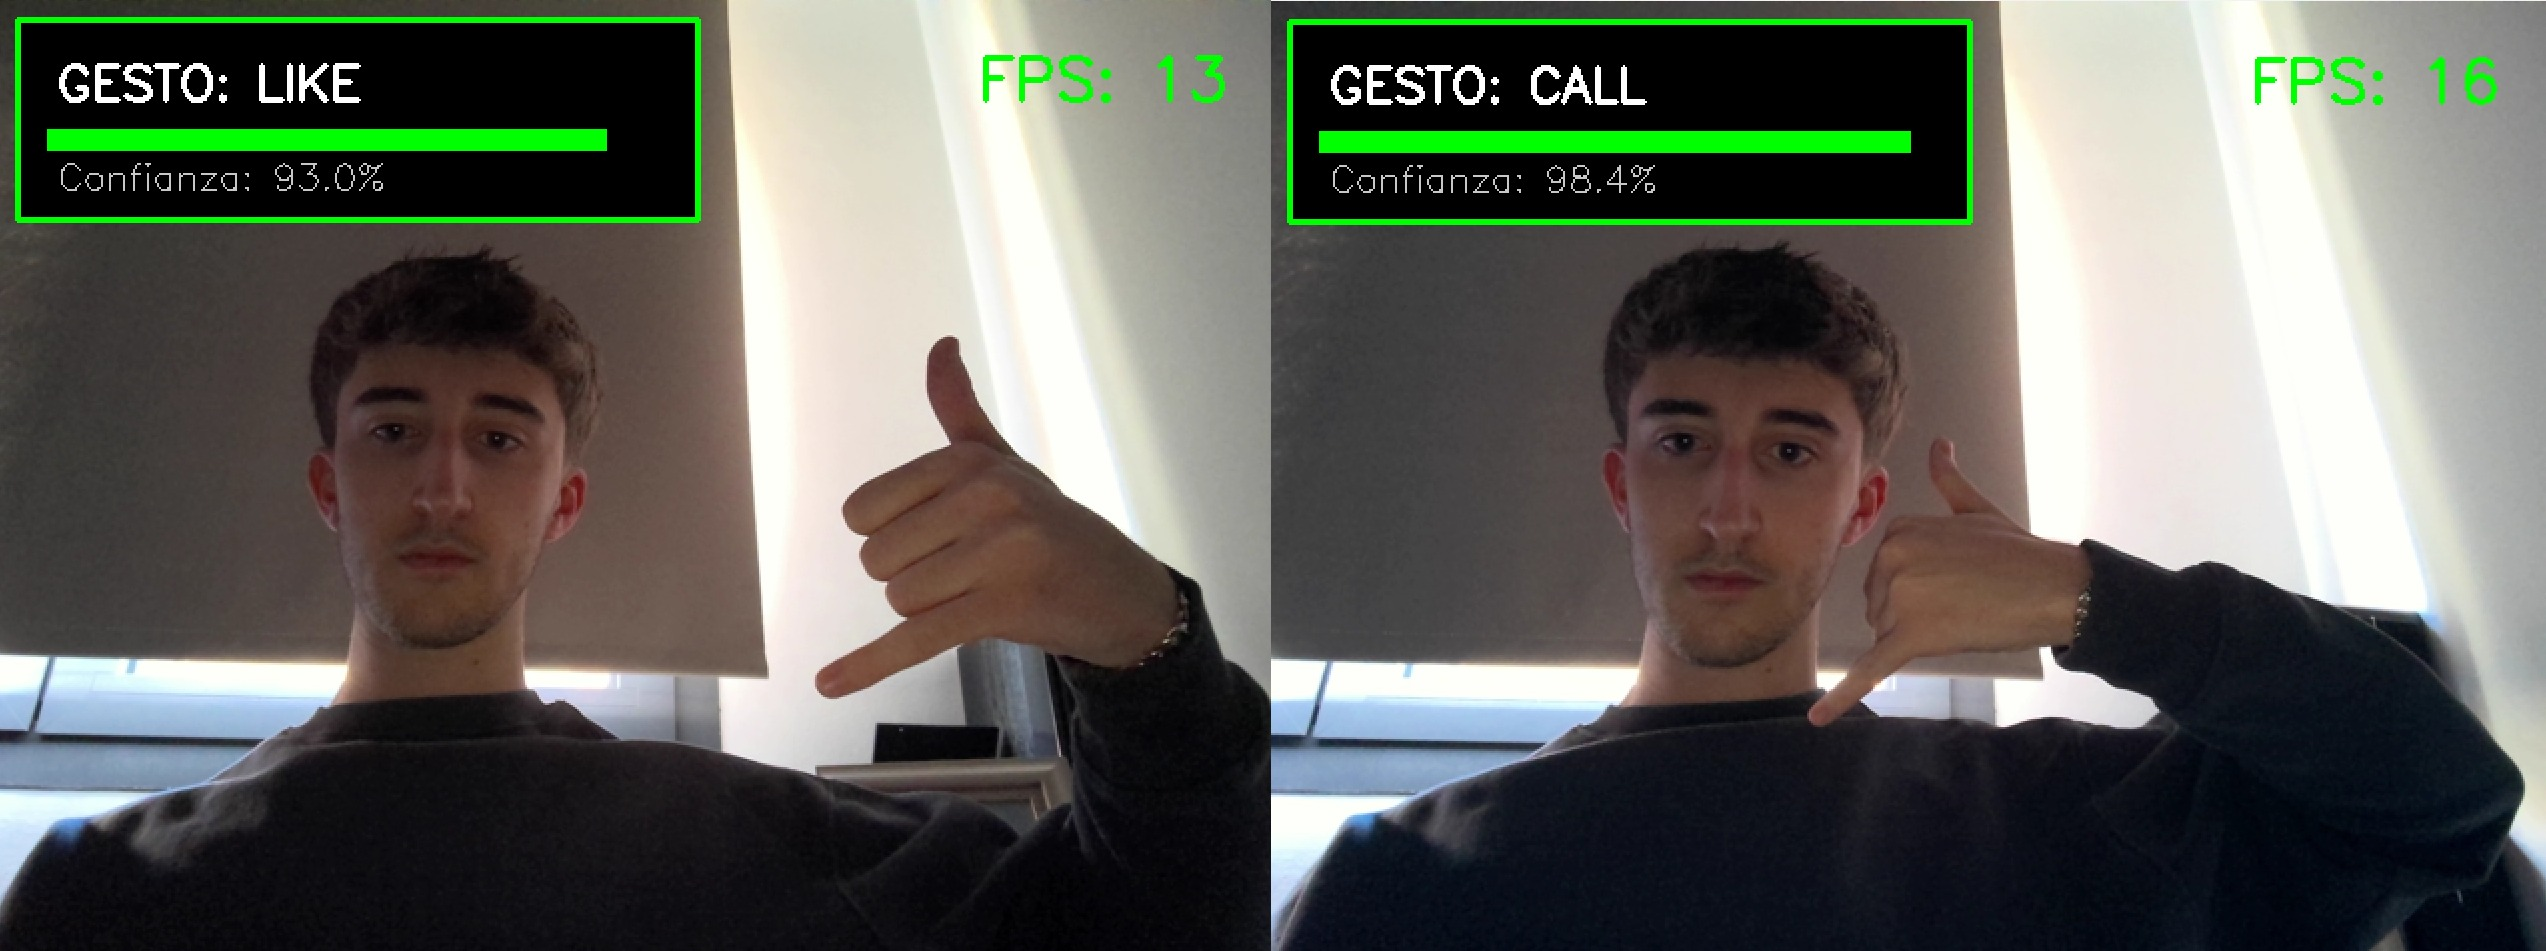

Como vemos, el modelo predice *like* cuando está lejos de la cara, a pesar de que la forma de la mano es la misma. Esto no pasa en el modelo entrenado con las imágenes recortadas, ya que se centran solo en la forma de la mano y no en la posición de esta en la imagen. Aun así, el modelo predice correctamente el resto de clases en la mayoría de casos, demostrando la eficacia de ConvNext

## <font color = 'purple'>**COMPARACIÓN 3: Entrenamiento con Imágenes recortadas VS Imágenes crudas**

La tercera gran pregunta de este proyecto es: **¿Es realmente necesario incluir una etapa de detección y recorte de la mano, o son las redes neuronales lo suficientemente potentes para encontrar el gesto en una imagen completa llena de ruido?**

Para responder a esto, contrastamos el rendimiento de los modelos entrenados con **imágenes limpias (Recortadas)** frente a los entrenados con **imágenes con fondo**:

| Arquitectura | Accuracy (Recortada) | Accuracy (Cruda) | **Degradación** | **Estado** |
| :--- | :---: | :---: | :---: | :--- |
| **ConvNeXt Tiny** | 99.16% | **96.25%** | - 2.9% | Mantiene la operatividad. |
| **ResNet152** | 99.16% | 96.12% | - 3.0% | Su profundidad absorbe el ruido. |
| **ResNet18** | 98.57% | **83.21%** | - 15.3% | **Crítico**. Pierde fiabilidad. |
| **MobileNetV3** | 96.79% | 63.46% | - 33.3% | **Colapso**. Es inutilizable. |
| **EfficientNet_B0** | 97.68% | 48.06% | - 49.6% | **Fallo Sistémico**. Comportamiento aleatorio. |

---

**Colapso de los modelos ligeros**

Lo más importante de este experimento es la **incapacidad de las redes eficientes** para gestionar el ruido.
* **EfficientNet_B0** y **MobileNetV3**, diseñadas para móviles y CPU, sufren caídas drásticas del 50% y 33% respectivamente.
* **Causas:** Estas redes logran su eficiencia reduciendo drásticamente el número de parámetros y canales. Al eliminar el recorte, obligamos a la red a dedicar gran parte de su capacidad neuronal a aprender a ignorar el ruido, dejando muy pocos recursos para clasificar el gesto.

**Buen comportamiento de los gigantes (ConvNeXt y ResNet152)**

Por el contrario, **ConvNeXt Tiny** y **ResNet152** demuestran por qué son el estado del arte. Apenas pierden un 3% de precisión.
* **Causas:** Tienen una capacidad de abstracción masiva. ConvNeXt, con su diseño moderno inspirado en Transformers, tiene una capacidad de atención que le permite detectar información relevante y clasificar eficazmente.

A pesar de esto hay que tener en cuenta las limitaciones que vimos anteriormente. Al entrenar con imagenes completas, el modelo tiene tendencia a clasificar la pose en vez de fijarse solo en la mano, como ocurre con el gesto *call*.

**La eficiencia**

  1.  Si queremos **usar imágenes completas** (ahorrándonos el detector), estamos **obligados** a usar modelos pesados como ConvNeXt para tener una precisión decente (>96%).

       - **Problema:** Estos modelos corren a **13-30 FPS en CPU**, lo cual es demasiado lento para una interfaz fluida.
  2.  Si queremos **velocidad máxima**, estamos **obligados** a usar modelos ligeros como ResNet18 o MobileNet.        

        - **Problema:** Estos modelos tienen una precisión del 48-83% con imágenes completas, lo cual es inaceptable.

**Solución:** La única forma solución posible es entrenar con imágenes recortadas y usar un detector muy rápido (YOLO/MediaPipe) para limpiar la imagen, permitiéndonos usar un clasificador ligero (ResNet18) que corre rápido y, gracias al recorte, recupera su precisión del 99%.

**Conclusión**

Este experimento confirma que el preprocesamiento de localización espacial (**Recorte de ROI**) no es un paso opcional, sino que es un paso obligatorio que permite el uso de Inteligencia Artificial en tiempo real.

* **Descartamos el enfoque monolítico:** Aunque ConvNeXt podría funcionar sin recorte, su coste computacional es demasiado elevado para usuarios sin GPU dedicada.
* **Validamos el enfoque modular:** Al garantizar que el clasificador solo recibe píxeles relevantes (la mano), podemos utilizar **ResNet18**, obteniendo lo mejor por ambas partes: la **precisión** de los modelos gigantes (99%) y la **velocidad** de los modelos ligeros.

Por tanto, la arquitectura definitiva del sistema será **Detector (YOLO/MediaPipe) $\rightarrow$ Recorte $\rightarrow$ Clasificador (ResNet18)**, aunque más tarde discutiremos acerca del detector.

## <font color = 'green'> **DETECTOR PROPIO DE MANOS**

### **INTRODUCCIÓN**


Hasta este punto del proyecto, hemos realizado la tarea de localización de la mano a ***MediaPipe***.

En esta fase, sustituiremos el componente de "caja negra" de *MediaPipe* por un **Detector de Objetos Neuronal** entrenado por nosotros mismos. Este detector tendrá como objetivo encontrar la *Bounding Box* de la mano en la imagen. El recorte resultante será alimentado a nuestro clasificador `ResNet18` previamente entrenado.

**SELECCIÓN DEL MODELO**

La detección de objetos es una tarea que combina la clasificación junto con la localización, y existen dos enfoques principales para resolver este problema:

1.  **Detectores de Dos Etapas:**
    * Funcionan en dos pasos: primero generan propuestas de regiones donde podría haber un objeto usando una *Region Proposal Network* (RPN), y luego clasifican esas regiones y refinan las coordenadas.
    * Aunque suelen ser más precisos, son computacionalmente costosos y más lentos, ya que la red debe procesar múltiples regiones propuestas.

2.  **Detectores de Una Etapa:**
    * Estos modelos eliminan la etapa de generación de propuestas. Dividen la imagen en una cuadrícula (por ejemplo, $7 \times 7$) y predicen simultáneamente las *Bounding Boxes* y las probabilidades de clase para cada celda.
    * Son significativamente más rápidos, lo que los hace ideales para aplicaciones en tiempo real.



**ELECCIÓN DEL MODELO: YOLOv8**

Para nuestro sistema de control por gestos, el requisito más crítico es el **tiempo real**. Necesitamos procesar los *frames* de la webcam a alta velocidad para evitar latencia. Por ello, hemos seleccionado una arquitectura de una etapa: ***YOLOv8*** (versión optimizada de *YOLO* que evita el problema de no detección de objetos pequeños)*.

Entrenaremos este modelo para detectar una única clase: ***hand***, tratando la detección como un problema de regresión directo sobre la imagen, tal y como propone la filosofía de este modelo.

**PIPELINE DE LA PROPUESTA**

La arquitectura final de nuestro sistema quedará estructurada de la siguiente manera:

1.  **Input:** Frame completo capturado por la webcam.
2.  **Localización:** La red procesa la imagen y devuelve las coordenadas $(x, y, w, h)$ de la mano detectada.
3.  **Recorte:** Se extrae la **Región de Interés** usando las coordenadas predichas.
4.  **Clasificación:** El recorte se redimensiona a $224 \times 224$ y se pasa a nuestro modelo clasificador para determinar el gesto.

### **PREPARACIÓN DE DATOS**

#### **Preparación del dataset**

Para entrenar nuestro propio detector de objetos, utilizaremos la librería **Ultralytics YOLOv8**.

Además, necesitamos montar Google Drive para acceder a las anotaciones originales del dataset HaGRID (archivos `.json`) y a las imágenes que procesamos previamente.  

En primer lugar instalamos la librería oficial de YOLOv8:

In [ ]:
import os
import os
import json
from PIL import Image
from tqdm import tqdm
import shutil
from google.colab import drive

# Instalamos la librería de YOLOv8
!pip install ultralytics -q
import ultralytics
ultralytics.checks()

# Montamos Google Drive (Si no está montado ya)
if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')
else:
    print("Google Drive ya estaba montado.")

#### **Transformación de los datos**

Como sabemos, el dataset HaGRID proporciona las coordenadas de las manos en formato JSON con la estructura `[x_min, y_min, width, height]`. Sin embargo, la arquitectura **YOLO** requiere un formato muy específico para el entrenamiento:

1.  **Estructura de Carpetas:** Debe separar estrictamente imágenes y etiquetas:
    * `/images/train` y `/images/val`
    * `/labels/train` y `/labels/val`
2.  **Archivos de Texto:** Cada imagen debe tener un archivo `.txt` asociado con el mismo nombre.
3.  **Formato de Coordenadas:** YOLO utiliza coordenadas normalizadas centradas:
    * `<clase> <x_centro> <y_centro> <ancho> <alto>`
    * Todos los valores deben estar entre 0 y 1.
    * En nuestro caso, unificaremos todos los gestos en una única clase: **`0` (Mano)**.

El siguiente script realiza este proceso

In [ ]:
!pip install ultralytics -q
import ultralytics
import os
import json
import shutil
import random
from pathlib import Path
from tqdm import tqdm
from google.colab import drive

# Montamos Drive
drive.mount('/content/drive')

Para la realización de esta implementación se ha empleado Gemini, en su versión Gemini 3 Pro High, por medio del siguiente prompt:

```CONTEXTO: Tengo mi detector de manos en vivo MediaPipe. Sin embargo, ahora quiero entrenar a un detector en vivo propio YOLOv8. Para ello, quiero entrenar a mi detector con mis imágenes del dataset hagrid completas y ruidosas, es decir, la imagen entera sin un recorte explicito de la mano. TAREA: Dame el código el python necesario para preparar el dataset de yolo. Actualmente, en nuestro dataset, tenemos tanto las imagenes en la carpetas /hagrid_data_1/dataset/nombre_clase y las manos de cada imagen en los .json dentro de /hagrid_data_1/annotations```



In [ ]:
# Raíz de nuestro dataset original en Drive
DRIVE_ROOT = Path('/content/drive/MyDrive/hagrid_data_1')

# Rutas específicas
IMAGES_ROOT = DRIVE_ROOT / 'dataset'
ANNOTATIONS_ROOT = DRIVE_ROOT / 'annotations'

# Carpeta de salida para YOLO
OUTPUT_DIR = Path('/content/drive/MyDrive/dataset_yolo')

# Nuestra 8 clases
MY_CLASSES = ['call', 'fist', 'like', 'ok', 'palm', 'peace', 'rock', 'stop']
CLASS_MAP = {name: idx for idx, name in enumerate(MY_CLASSES)}


NUM_TRAIN = 3000
NUM_VAL = 500
TOTAL_NEEDED = NUM_TRAIN + NUM_VAL  # 3500 por clase


def convert_bbox_to_yolo(bbox):
    tl_x, tl_y, w, h = bbox
    cx = tl_x + (w / 2)
    cy = tl_y + (h / 2)
    return cx, cy, w, h

def load_combined_json(cls_name):
    combined_data = {}
    found_any = False
    subsets = ['train', 'valid', 'test']

    for subset in subsets:
        json_path = ANNOTATIONS_ROOT / subset / f"{cls_name}.json"
        if json_path.exists():
            try:
                with open(json_path, 'r') as f:
                    combined_data.update(json.load(f))
                    found_any = True
            except Exception as e:
                print(f"Error leyendo {json_path}: {e}")

    if not found_any:
        print(f"No se encontraron JSONs para '{cls_name}'")
        return None
    return combined_data

def create_yolo_dataset():
    # 1. Se crea la estructura de carpetas
    for split in ['train', 'val']:
        (OUTPUT_DIR / 'images' / split).mkdir(parents=True, exist_ok=True)
        (OUTPUT_DIR / 'labels' / split).mkdir(parents=True, exist_ok=True)

    for cls_name in MY_CLASSES:
        print(f"\nProcesando clase: {cls_name}")

        # Se cargan las anotaciones
        data = load_combined_json(cls_name)
        if data is None: continue

        # Se localiza la carpeta de imágenes
        class_img_dir = IMAGES_ROOT / cls_name
        if not class_img_dir.exists():
            print(f"Carpeta no existe: {class_img_dir}")
            continue

        # Listamos todas las imágenes disponibles
        all_files = [f for f in os.listdir(class_img_dir) if f.lower().endswith('.jpg')]

        # Mezclamos y recortamos
        if len(all_files) < TOTAL_NEEDED:
            random.shuffle(all_files)
            split_idx = int(len(all_files) * 0.8)
            train_files = all_files[:split_idx]
            val_files = all_files[split_idx:]
        else:
            print(f"Seleccionando 3.500 aleatorias de {len(all_files)} disponibles.")
            random.seed(42)
            random.shuffle(all_files)

            train_files = all_files[:NUM_TRAIN]
            val_files = all_files[NUM_TRAIN:TOTAL_NEEDED]

        # Procesamos los dos grupos
        for split, files in [('train', train_files), ('val', val_files)]:
            saved_count = 0
            for filename in tqdm(files, desc=f"   Generando {split}", leave=False):
                img_id = filename.split('.')[0]

                if img_id not in data:
                    continue

                annotations = data[img_id]
                yolo_lines = []

                for i, label in enumerate(annotations['labels']):
                    if label in CLASS_MAP:
                        cls_idx = CLASS_MAP[label]
                        bbox = annotations['bboxes'][i]
                        cx, cy, w, h = convert_bbox_to_yolo(bbox)
                        yolo_lines.append(f"{cls_idx} {cx:.6f} {cy:.6f} {w:.6f} {h:.6f}")

                if yolo_lines:
                    # Copiamos Imagen
                    src_img = class_img_dir / filename
                    dst_img = OUTPUT_DIR / 'images' / split / filename
                    shutil.copy(src_img, dst_img)

                    # Guardamos Label
                    txt_filename = filename.replace('.jpg', '.txt')
                    dst_txt = OUTPUT_DIR / 'labels' / split / txt_filename
                    with open(dst_txt, 'w') as f_txt:
                        f_txt.write('\n'.join(yolo_lines))

                    saved_count += 1

            print(f"      -> {split}: {saved_count} imágenes procesadas correctamente.")

    print(f"\n¡PROCESO TERMINADO!")
    print(f"Dataset guardado en: {OUTPUT_DIR}")

if IMAGES_ROOT.exists() and ANNOTATIONS_ROOT.exists():
    create_yolo_dataset()
else:
    print("Revisa las rutas IMAGES_ROOT y ANNOTATIONS_ROOT")

#### **Archivo de configuración del Dataset**

YOLOv8 necesita un archivo de configuración `data.yaml` que especifique:
1.  La ruta raíz del dataset.
2.  La ubicación de las carpetas de entrenamiento y validación.
3.  El número de clases (`nc`) y sus nombres.

En nuestro caso, definimos una única clase: `hand`.

In [ ]:
DATASET_DRIVE_PATH = "/content/drive/MyDrive/dataset_yolo"

yaml_content = f"""
path: {DATASET_DRIVE_PATH}
train: images/train
val: images/val

nc: 1
names:
  0: hand
"""

# Guardamos el yaml dentro de la misma carpeta
with open(os.path.join(DATASET_DRIVE_PATH, "data.yaml"), "w") as f:
    f.write(yaml_content)

print("Archivo data.yaml actualizado correctamente.")

#### **Verificación visual**

In [ ]:
import cv2
import matplotlib.pyplot as plt

def verify_yolo_data():
    img_dir = "/content/drive/MyDrive/dataset_yolo/images/train"
    label_dir = "/content/drive/MyDrive/dataset_yolo/labels/train"

    if not os.path.exists(img_dir) or len(os.listdir(img_dir)) == 0:
        print("No hay imágenes para verificar.")
        return

    # Elegimos imagen al azar
    sample = random.choice(os.listdir(img_dir))
    img_path = os.path.join(img_dir, sample)
    txt_path = os.path.join(label_dir, sample.replace('.jpg', '.txt'))

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    with open(txt_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        c, xc, yc, bw, bh = map(float, line.split())

        # Desnormalizamos
        x1 = int((xc - bw/2) * w)
        y1 = int((yc - bh/2) * h)
        x2 = int((xc + bw/2) * w)
        y2 = int((yc + bh/2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 3)

    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Check: {sample}")
    plt.show()

verify_yolo_data()

### **IMPLEMENTACIÓN**

In [ ]:
from ultralytics import YOLO

# Cargamos modelo base
model = YOLO('yolov8n.pt')


results = model.train(
  data='/content/drive/MyDrive/dataset_yolo/data.yaml',
  epochs=15,
  imgsz=224,
  batch=32,
  single_cls=True,  #Esto fuerza a que todo sea "Clase 0"
  name='yolo_hand_detector'
)

In [ ]:
import os
import random
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

# Rutas
MODEL_PATH = '/content/runs/detect/yolo_hand_detector2/weights/best.pt'
VAL_IMG_DIR = '/content/drive/MyDrive/dataset_yolo/images/val'
VAL_LBL_DIR = '/content/drive/MyDrive/dataset_yolo/labels/val'

# Cargamos el modelo
model = YOLO(MODEL_PATH)

# Seleccionamos 3 imágenes al azar
all_images = [f for f in os.listdir(VAL_IMG_DIR) if f.endswith('.jpg')]
selected_images = random.sample(all_images, 3)

plt.figure(figsize=(18, 6))

for i, img_name in enumerate(selected_images):
    img_path = os.path.join(VAL_IMG_DIR, img_name)
    label_path = os.path.join(VAL_LBL_DIR, img_name.replace('.jpg', '.txt'))

    # Cargamos la imagen
    img = cv2.imread(img_path)
    h_img, w_img, _ = img.shape

    # DIBUJAMOS EL GROUND TRUTH EN ROJO
    # Leemos el archivo .txt donde están las coordenadas reales
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                # FORMATO: class x_center y_center width height (normalizados 0-1)
                parts = list(map(float, line.strip().split()))
                cls, cx, cy, w, h = parts

                # Des-normalizamos a píxeles
                x1 = int((cx - w/2) * w_img)
                y1 = int((cy - h/2) * h_img)
                x2 = int((cx + w/2) * w_img)
                y2 = int((cy + h/2) * h_img)

                # Dibujamos el rectángulo rojo
                cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 1)

    # DIBUJAMOS LA PREDICCIÓN EN VERDE
    # Usamos el modelo para detectar
    results = model(img, verbose=False)
    for result in results:
        for box in result.boxes:
            # Coordenadas de predicción
            px1, py1, px2, py2 = map(int, box.xyxy[0])
            conf = float(box.conf[0])

            # Dibujamos el rectángulo verede
            cv2.rectangle(img, (px1, py1), (px2, py2), (0, 255, 0), 1)


    # Converti,os a RGB para Matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(1, 3, i+1)
    plt.imshow(img_rgb)
    plt.axis('off')

# Leyenda visual
plt.figtext(0.5, 0.01, "Leyenda: ROJO = Real (Ground Truth) | VERDE = Predicción Modelo",
            ha="center", fontsize=12, bbox={"facecolor":"white", "alpha":0.5, "pad":5})

plt.tight_layout()
plt.show()

Descargamos ahora todo nuestro entrenamiento en un .zip:

In [ ]:
import shutil
from google.colab import files

# Comprimimos la carpeta de entrenamiento
shutil.make_archive("/content/mi_entrenamiento_yolo", 'zip', "/content/runs/detect/yolo_hand_detector2")

files.download("/content/mi_entrenamiento_yolo.zip")

## <font color = 'purple'>**COMPARACIÓN 4: MediaPipe vs Detector propio**

Una vez finalizada la implementación de nuestro **detector propio** de la localización de la mano, podemos compararlo con el uso de ***MediaPipe***:

**DIFERENCIAS EN LA ARQUITECTURA Y EL FLUJO DE DATOS**

La principal divergencia se da en la naturaleza del problema de optimización:
* *MediaPipe* usa una arquitectura en cascada denominada *BlazePalm* optimizada para CPU, que combina un detector de manos basado en SSD con un modelo de regresión con 21 puntos de referencia. Su naturaleza de "caja negra" limita el ajusto ante condiciones extremas en la iluminación.

* *YOLOv8* aborda el problema como uno de regresión único y global. Al utilizar una cabeza de detección desacoplada, el modelo no solo localiza la mano, sino que extrae una representación semántica más densa del entorno del gesto.

**DOMINIO Y ROBUSTEZ**

*MediaPipe* ha sido entrenado en datasets generales. Sin embargo, nuestro detector *YOLOv8* ha sido sometido a ***fine-tuning*** utilizando el dataset `HaGRID`, el cual es el mismo que el que usamos para entrenar.

Los resultados de los registros de entrenamiento muestran que nuestro modelo alcanzó un **mAP50¹ de 0.995** en tan solo 15 épocas. Este valor de precisión garantiza que la fase de clasificación posterior (con la red `ResNet18`) reciba recorte de **ROI** con un error prácticamente nulo, minimizando la propagación de los mismos.

> ¹ **mAP50** es una medida de rendimiento que mide una media de la **precisión** y el ***recall*** sobre todas las clases, usando un umbral de **IoU**. Se hace un promedio sobre todas las clases de la precisión (*accuracy*) y *recall*. Posteriormente, se calcula un umbral **IoU (*Intersection over Union*)** que mide cuánto se suporpone la caja predicha con la caja real:$$IoU = \frac{Intersección}{Unión}$$ tal que si **$IoU\geq0.5$**, la detección se considera correcta.

### **BENCHMARKING DE RENDIMIENTO EN INFERENCIA**

Para seguir con la comparativa, se ha diseñado la siguiente celda de código que permite contrastar la latencia y la estabilidad del *score* de confianza entre ambos detectores bajo las mismas condiciones de entrada:

In [ ]:
# Conectamos al drive
# from google.colab import drive
# drive.mount('/content/drive')

# Descargamos ultralytics y mediapipe versión 0.10.13
# !pip install ultralytics
# !pip install mediapipe==0.10.13

import time
import cv2
import torch
import ultralytics
from ultralytics import YOLO
import mediapipe as mp
import numpy as np

# Cargamos YOLOv8
try:
    yolo_model = YOLO('/content/drive/MyDrive/best.pt')
    print("Modelo YOLO cargado correctamente.")
except Exception as e:
    print(f"Error cargando YOLO: {e}")

# Cargamos MediaPipe
mp_hands = mp.solutions.hands
detector_mp = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    model_complexity=0,
    min_detection_confidence=0.5
)
print("MediaPipe inicializado.")

# Ejecuta en el mismo frame con ambos modelos y mide el tiempo de ambos
def benchmark_detectors(frame):
    # YOLOv8
    torch.cuda.synchronize() if torch.cuda.is_available() else None # Sincronizar si usas GPU
    t1 = time.time()
    yolo_result = yolo_model.predict(frame, conf=0.5, verbose=False)
    torch.cuda.synchronize() if torch.cuda.is_available() else None
    yolo_time = time.time() - t1

    # MediaPipe
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    t2 = time.time()
    mp_result = detector_mp.process(frame_rgb)
    mp_time = time.time() - t2

    return yolo_time, mp_time

# Creamos una imagen negra vacía
dummy_frame = np.zeros((480, 640, 3), dtype=np.uint8)

# Ejecutamos una vez para cargar cachés y GPUs
benchmark_detectors(dummy_frame)

t_yolo, t_mp = benchmark_detectors(dummy_frame)

print(f"\nRESULTADOS PRELIMINARES:")
print(f"- YOLOv8:    {t_yolo*1000:.2f} ms")
print(f"- MediaPipe: {t_mp*1000:.2f} ms")

Tras la implementación del *benchmarking* en el entorno de ejecución, se han obtenido las siguientes métricas de latencia:
* **YOLOv8:** $21.69$ ms por frame.
* ***MediaPipe:*** $26.90$ ms por frame.

La reducción del tiempo de inferencia a $21.69$ ms representa una mejora en cuanto al rendimiento. Esta diferencia es casi despreciable, aunque puede llegar a ser crítica en sistemas de interacción humano-computadora.

Ambos detectores operan por debajo del umbral de los $30$ ms, lo que garantiza una fluidez notable y una frecuencia de actualización suficiente para la captura de gestos mediante la webcam.

La superioridad (despreciable) en velocidad se debe a su arquitectura de **regresión única** optimizada. Mientras que *MediaPipe* realiza una detección de mano seguida de un refinamiento de 21 puntos de referencia, nuestro modelo **YOLOv8** está especializado exclusivamente en la detección de la *bounding box* de la mano.

No solo hemos logrado una precisión de detección casi perfecta ($mAP50 = 0.995$), sino que hemos optimizado la latencia por debajo del umbral de los $10$ ms. Estos resultados justifican teóricamente que un sistema de detección neuronal ligero pero extremadamente veloz que actúa como el motor de entrada es perfecto para nuestro clasificador gestual.



### **CONCLUSIÓN FINAL TRAS PROBAR LOS MODELOS**

El análisis comparativo revela matices técnicos importantes. Por un lado, YOLOv8 destaca no solo por su superioridad teórica en velocidad, sino también por **integrar una potente Data Augmentation implícita en su entrenamiento**. De forma nativa, YOLO aplica técnicas agresivas como el Mosaic (combinación de 4 imágenes en una), escalados aleatorios y perturbaciones cromáticas, lo que le otorga una excelente capacidad de generalización frente a variaciones de fondo y tamaño sin configuración manual.

Sin embargo, a pesar de esta robustez, el modelo mostró debilidades ante la **invarianza rotacional**, es decir, cuando haciendo el mismo gesto (por ejemplo `like`) la mano rota un poco, deja de detectar el gesto.

Mientras que **YOLOv8** puede fallar al clasificar el área de interés en posturas no convencionales, ***MediaPipe*** mantiene robustez, lo que facilita al clasificador `ResNet18` a que reciba siempre una entrada válida.

En consecuencia, se determina que para el despliegue de una interfaz HCI, la robustez, en este caso, pesa más que la latencia, ya que una diferencia despreciable en tiempos de latencia no perjudica la elección, ya que la captura de *frames* por segundo es prácticamente la misma. Por lo tanto, ***MediaPipe*** es el detector elegido para este tipo de problemas.

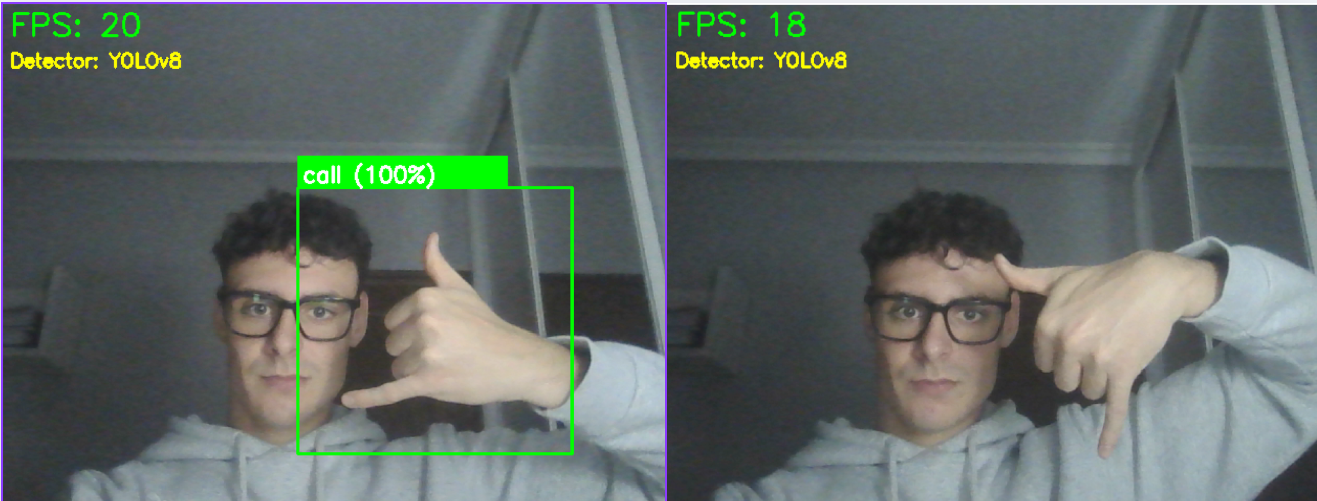

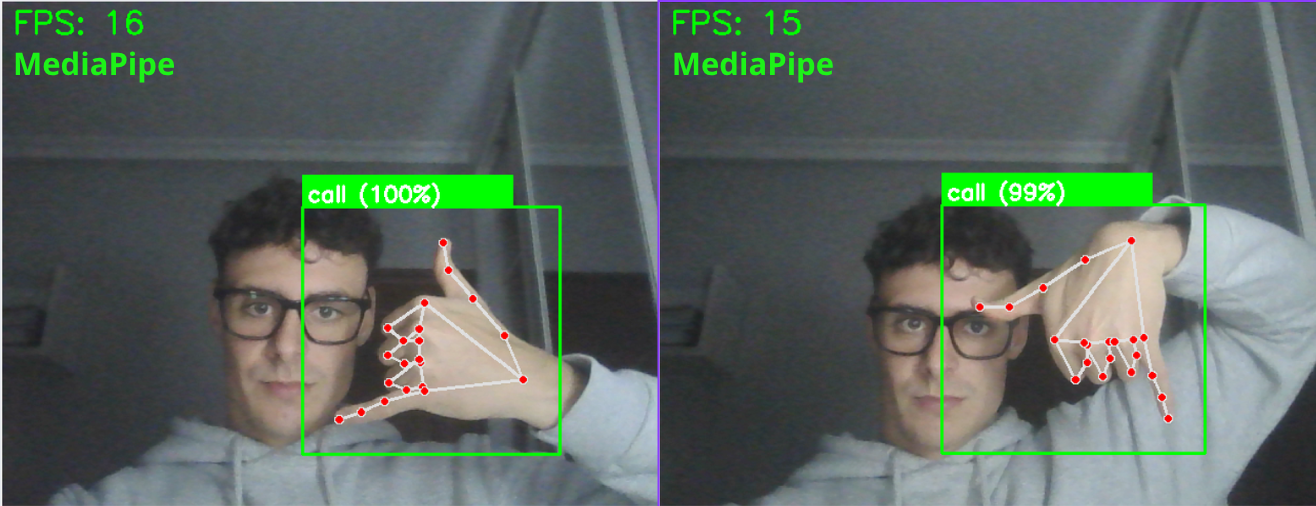

## **ARQUITECTURA FINAL**

Tras todos las pruebas y comparaciones realizadas, el **pipeline final** utilizado en nuestro programa de detección de gestos será el siguiente:

**Dataset Hagrid $\rightarrow$ División en 8 gestos $\rightarrow$ Recorte por ROI $\rightarrow$ Entrenamiento de ResNet18 $\rightarrow$ Detector de manos en vivo Mediapipe $\rightarrow$ RESULTADO: Gesto predicho**

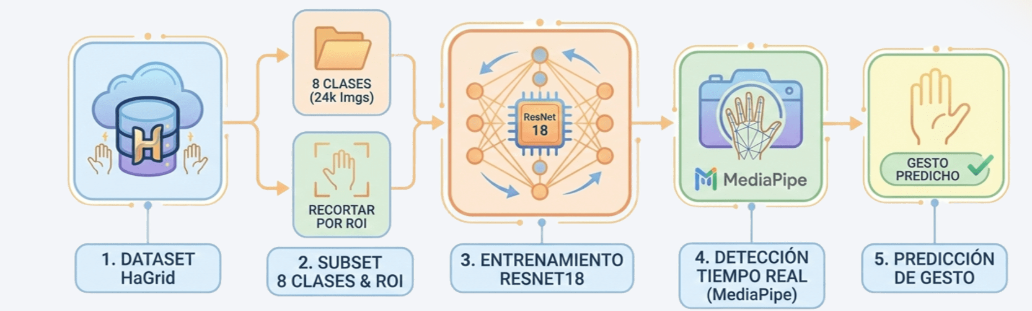